In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
import scipy.stats

In [2]:
particle_name = ['n', 'pi-', 'pi0_1', 'an', 'pi+', 'pi0_2']

### PtEtaPhi distributions after preprocessing

In [3]:
points=pickle.load(open('HiggsCP_data/rhorho/events_wo_background_PtEtaPhi_raw.pk','rb'))

In [4]:
var_name =['pT', 'eta', 'phi', 'E']

In [5]:
preprocessed_PtEtaPhi = pd.DataFrame(points.train.x)
preprocessed_PtEtaPhi.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), var_name*6])
# preprocessed_PtEtaPhi=pd.concat(PtEtaPhi,axis=1)
preprocessed_PtEtaPhi

n                                      pi-                      \
              pT       eta       phi          E        pT       eta       phi   
0       1.307865 -3.709932 -2.618819  26.729837  0.353738 -3.730524  1.013976   
1       1.505932 -3.873718 -1.621365  36.249082  0.374622 -4.285722  2.227690   
2       0.742283 -3.253883 -2.535755   9.623449  0.467577 -4.162218  2.433069   
3       2.096038 -4.502371 -2.218956  94.575220  0.148992 -3.414475  0.489358   
4       1.557747 -3.686628 -2.516190  31.104390  0.298760 -3.724983  2.004193   
...          ...       ...       ...        ...       ...       ...       ...   
799995  2.150934 -4.138069  0.790057  67.429218  0.286178 -4.336478  1.791648   
799996  1.364517 -4.076523 -0.938642  40.224004  0.389513 -4.563499  2.105517   
799997  1.659639 -4.026822  2.783435  46.553077  0.298522 -5.006769 -1.455666   
799998  1.673939 -4.354794 -1.003842  65.169516  0.351091 -4.350152 -0.612320   
799999  1.183107 -3.643923  0.587703  22.637403  0.361812 -4.762456 -1.699110   

                      pi0_1            ...        an                  pi+  \
                E        pT       eta  ...       phi          E        pT   
0        7.381160  0.353738 -4.696976  ...  0.133497  46.268843  0.302713   
1       13.612366  0.374622 -4.202284  ... -1.103688  36.487061  0.245248   
2       15.016743  0.467577 -4.370782  ... -2.430229  57.077727  0.152402   
3        2.271499  0.148992 -5.302279  ...  0.520988  17.721690  0.366740   
4        6.200035  0.298760 -4.770307  ...  0.566053  47.309570  0.438251   
...           ...       ...       ...  ...       ...        ...       ...   
799995  10.940191  0.286178 -4.398779  ... -2.070398  10.688841  0.187443   
799996  18.683277  0.389513 -4.584809  ... -1.488410  12.344823  0.328995   
799997  22.304159  0.298522 -4.109520  ...  0.615808  18.195758  0.213752   
799998  13.606048  0.351091 -4.688207  ...  2.355689   7.258589  0.155556   
799999  21.173959  0.361812 -3.726972  ...  2.483765  47.432027  0.288735   

                                          pi0_2                                 
             eta       phi          E        pT       eta       phi          E  
0       4.637970 -0.361800  15.642429  0.302713  4.296900  2.779792  11.123305  
1       3.653615 -0.247395   4.740237  0.245248  5.161659  2.894197  21.393339  
2       3.582059  0.354039   2.744907  0.152402  6.000689 -2.787553  30.763369  
3       4.023744 -1.682218  10.256451  0.366740  3.638750  1.459375   6.982296  
4       4.145003  3.111587  13.834898  0.438251  3.819469 -0.030006   9.993451  
...          ...       ...        ...       ...       ...       ...        ...  
799995  5.381515  0.553641  20.371370  0.187443  3.159633 -2.587951   2.216350  
799996  5.045555  0.383750  25.552951  0.328995  4.307241 -2.757843  12.214513  
799997  3.565712  0.498247   3.785225  0.213752  5.554469 -2.643345  27.616414  
799998  5.905080  0.145572  28.537014  0.155556  3.974317 -2.996020   4.142515  
799999  3.939729  1.842711   7.425286  0.288735  4.992497 -1.298881  21.267281  

[800000 rows x 24 columns]

#### Selection of CP odd and CP even events

In [6]:
cp_even_events = preprocessed_PtEtaPhi.iloc[(np.argmax(points.train.weights,axis=1)==0 )| (np.argmax(points.train.weights,axis=1)==10),:]
cp_eight_events = preprocessed_PtEtaPhi.iloc[np.argmax(points.train.weights,axis=1)==8,:]
cp_odd_events = preprocessed_PtEtaPhi.iloc[np.argmax(points.train.weights,axis=1)==4,:]

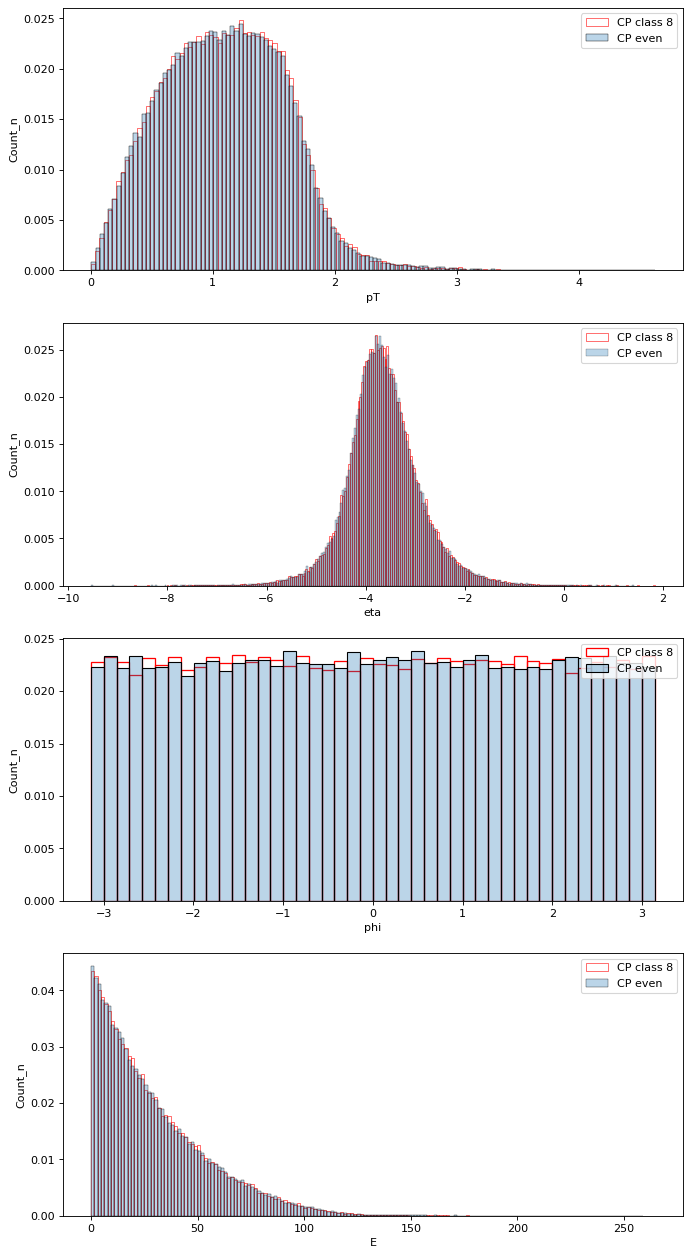

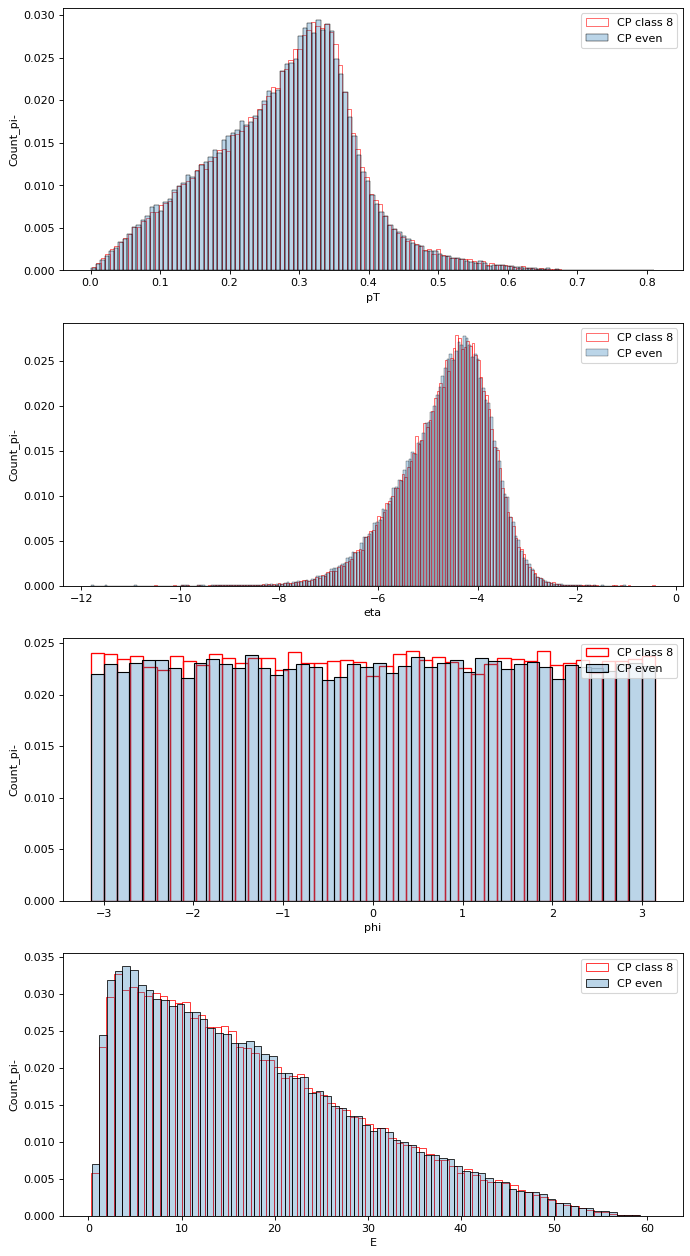

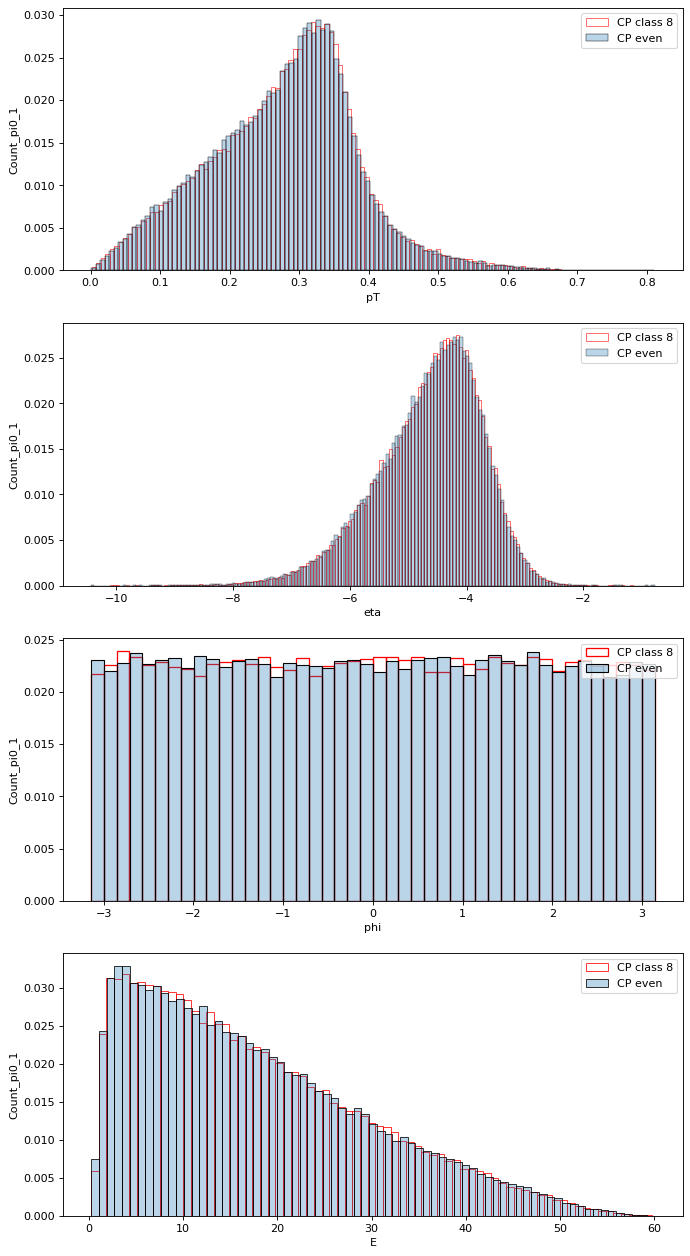

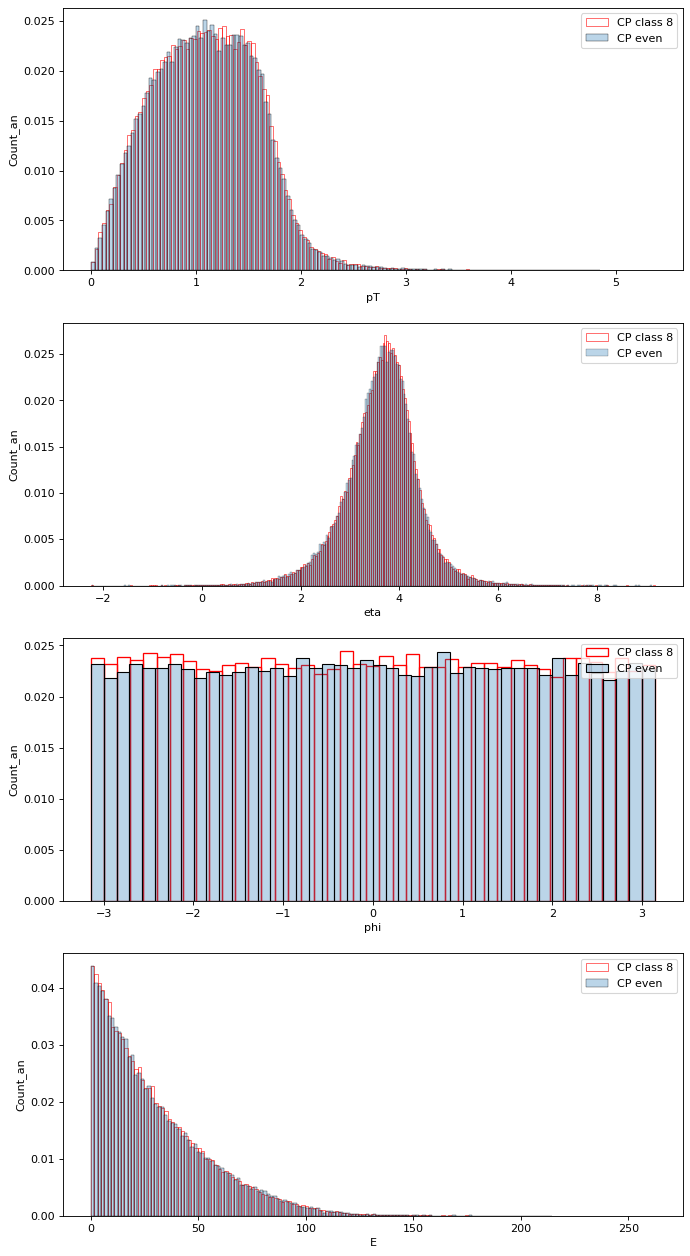

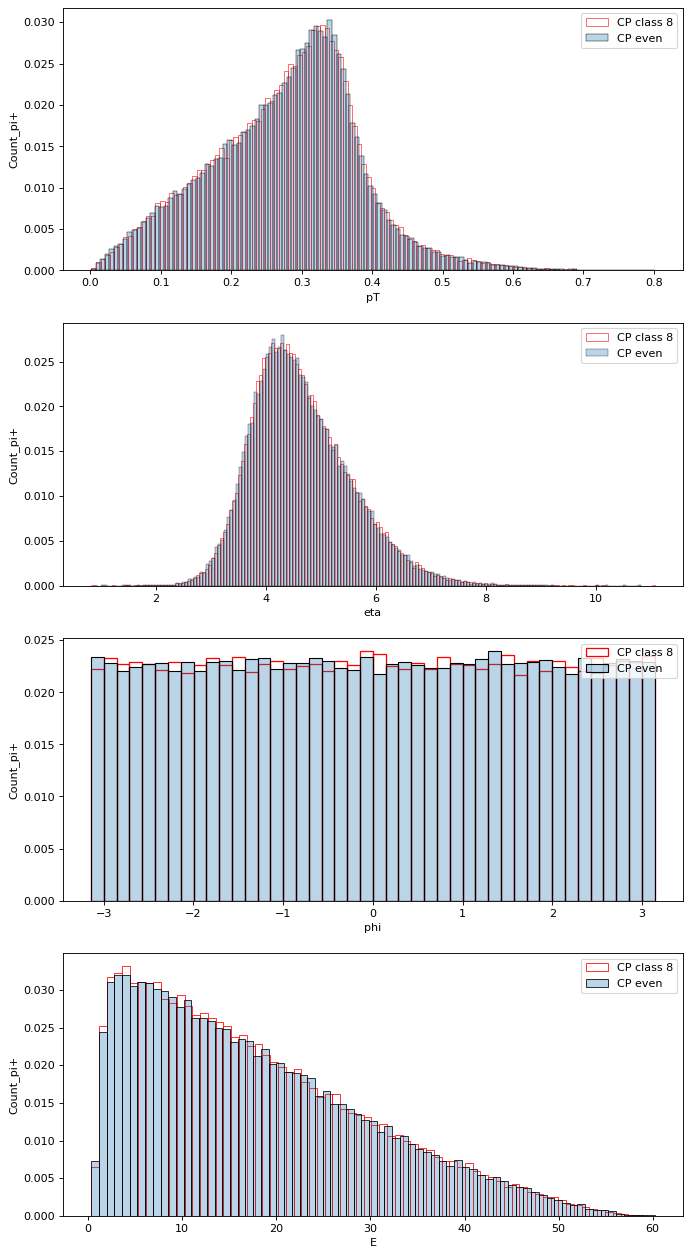

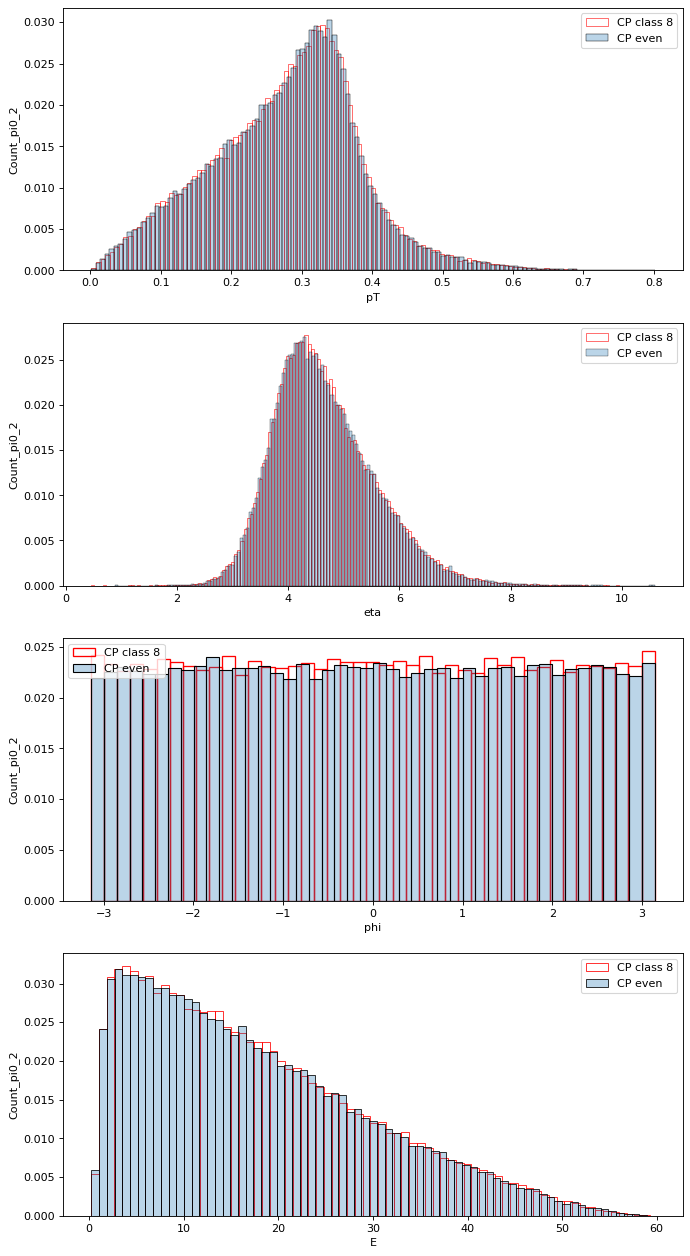

In [7]:
for particle in particle_name:
    fig,axis=plt.subplots(4,1,figsize=(10,20),dpi = 80)
    for var, ax in enumerate(axis):
        sns.histplot(data=cp_eight_events[particle], x = cp_eight_events[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP class 8')
#         sns.histplot(data=cp_odd_events[particle], x = cp_odd_events[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP odd')
        sns.histplot(data=cp_even_events[particle], x = cp_even_events[particle].columns[var], ax = ax,stat='probability',alpha=0.3,label='CP even')
        ax.set_ylabel('Count_'+str(particle),fontsize=10)
        ax.legend()
#     break

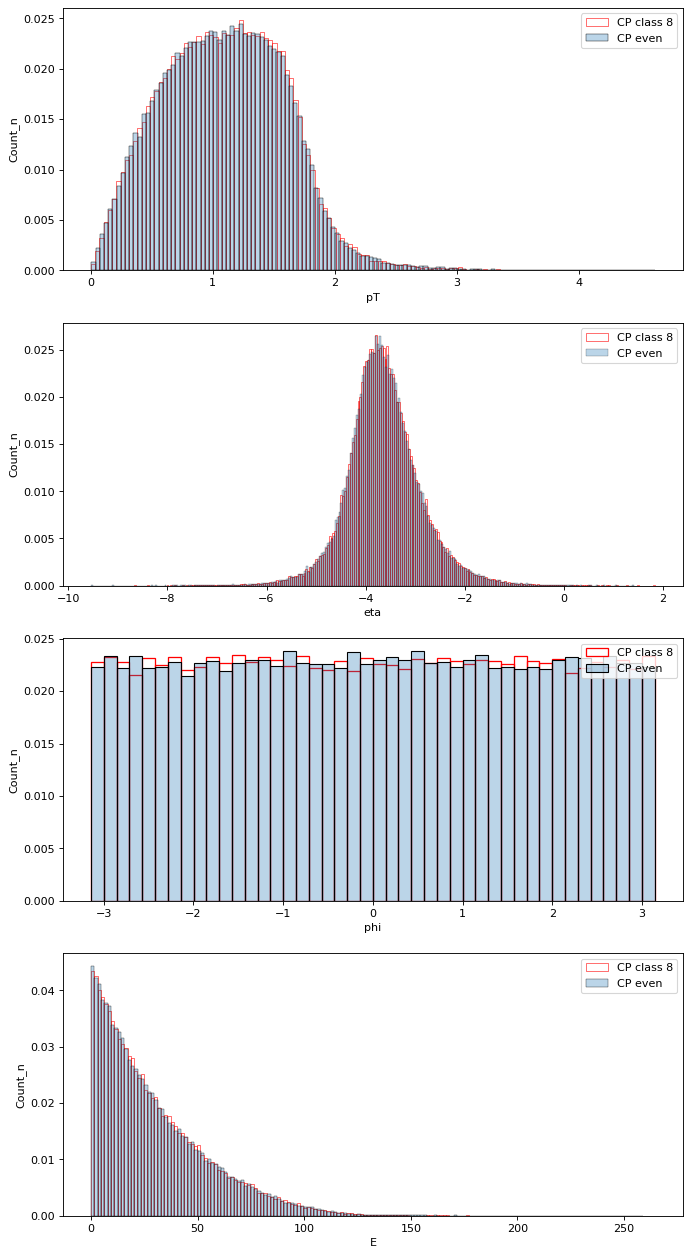

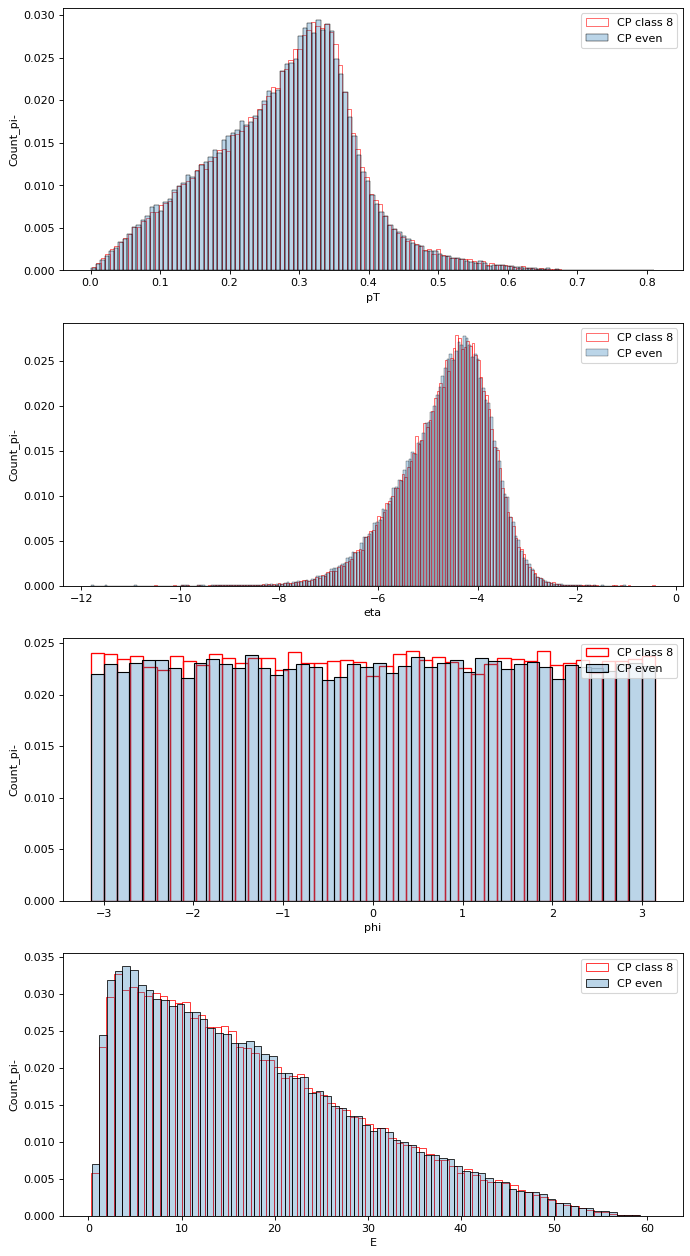

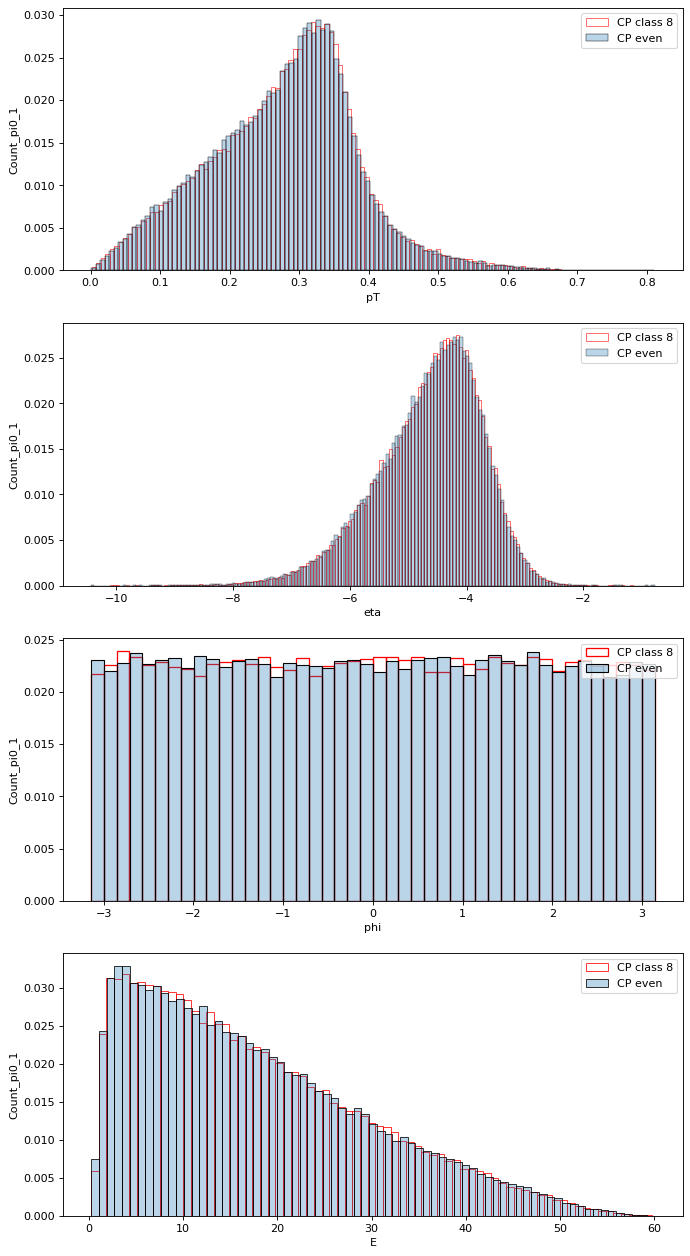

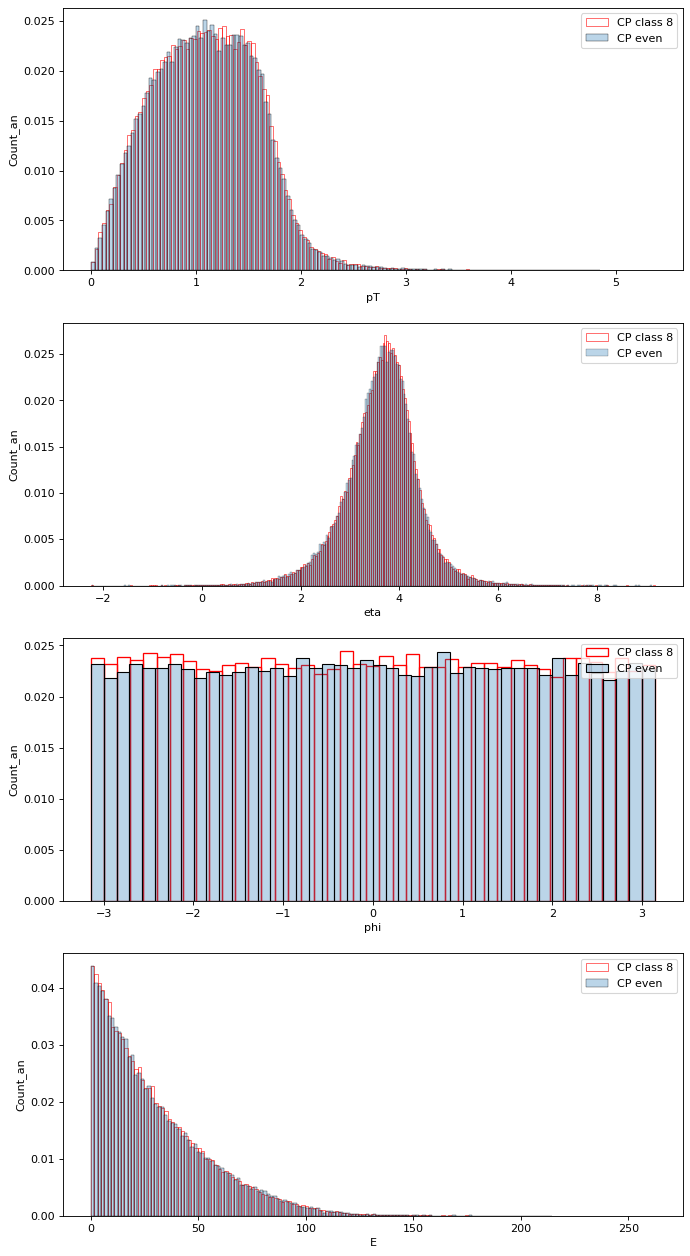

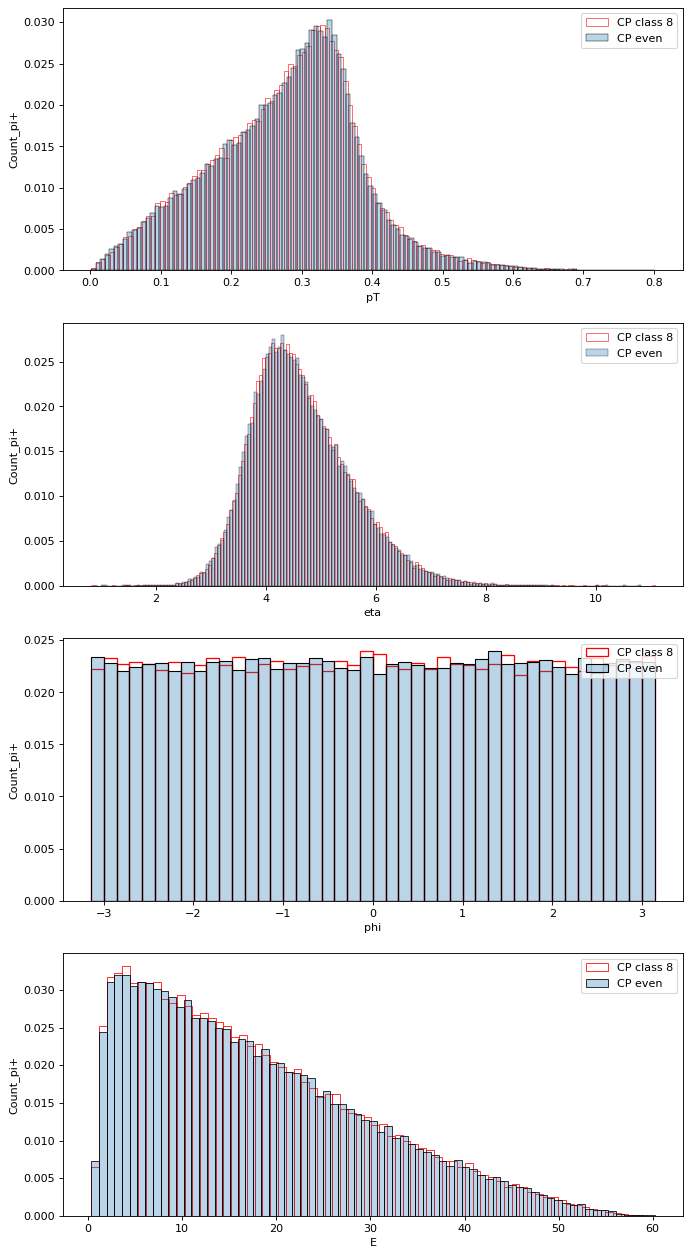

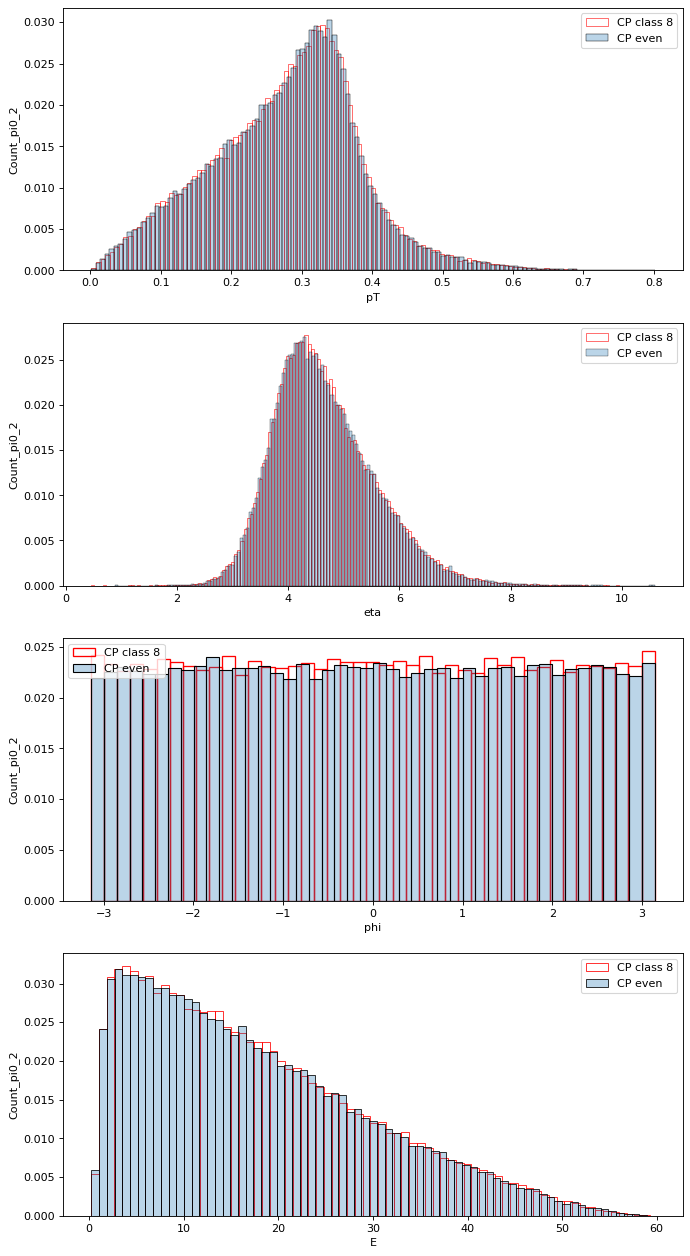

In [8]:
for particle in particle_name:
    fig,axis=plt.subplots(4,1,figsize=(10,20),dpi = 80)
    for var, ax in enumerate(axis):
        sns.histplot(data=cp_eight_events[particle], x = cp_eight_events[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP class 8')
#         sns.histplot(data=cp_odd_events[particle], x = cp_odd_events[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP odd')
        sns.histplot(data=cp_even_events[particle], x = cp_even_events[particle].columns[var], ax = ax,stat='probability',alpha=0.3,label='CP even')
        ax.set_ylabel('Count_'+str(particle),fontsize=10)
        ax.legend()
#     break

### P4 distributions after preprocessing

In [9]:
p4_points=pickle.load(open('HiggsCP_data/rhorho/events_wo_background_raw.pk','rb'))

In [10]:
preprocessed_p4 = pd.DataFrame(p4_points.train.x)
preprocessed_p4.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]),['p_x', 'p_y', 'p_z', 'E']*6])
# preprocessed_p4=pd.concat(PtEtaPhi,axis=1)
preprocessed_p4

n                                       pi-            \
             p_x       p_y        p_z          E       p_x       p_y   
0      -1.307081  0.388949 -27.416554  27.450451  0.271077 -0.232173   
1      -0.309066 -0.673588  -8.098986   8.132829  0.146034 -0.358638   
2       0.093819 -0.873710 -16.796019  16.818991 -0.151294  0.119564   
3       0.749797  0.180007 -54.212151  54.217636 -0.179662 -0.111452   
4       1.651500 -0.091217 -45.366900  45.397043 -0.220119  0.131030   
...          ...       ...        ...        ...       ...       ...   
799995  0.880736 -1.051825 -42.925227  42.947145  0.112848  0.218934   
799996 -0.161244 -0.508396  -4.135829   4.170089 -0.156454  0.042405   
799997  1.131230  0.282211 -24.063413  24.091643  0.140055  0.256855   
799998 -0.095413 -1.769399 -78.483539  78.503541 -0.020838 -0.327093   
799999  0.307981  2.260549 -82.938264  82.969636 -0.154378 -0.203641   

                                 pi0_1            ...         an             \
              p_z          E       p_x       p_y  ...        p_z          E   
0      -17.868313  17.872422 -0.271077  0.232173  ...  41.349676  41.386651   
1      -14.526210  14.532040 -0.146034  0.358638  ...  57.125270  57.152945   
2      -47.289611  47.290209  0.151294 -0.119564  ...   1.505293   1.526905   
3      -11.639596  11.642352  0.179662  0.111452  ...  44.635190  44.650347   
4      -26.283308  26.284926  0.220119 -0.131030  ...   8.800301   8.835538   
...           ...        ...       ...       ...  ...        ...        ...   
799995  -6.571752   6.577847 -0.112848 -0.218934  ...   1.317590   1.339512   
799996 -32.260162  32.260870  0.156454 -0.042405  ...  42.409822  42.437739   
799997  -9.569657   9.575146 -0.140055 -0.256855  ...  21.635542  21.640144   
799998 -10.790889  10.796767  0.020838  0.327093  ...   4.789969   4.831747   
799999 -11.750397  11.754002  0.154378  0.203641  ...   6.227573   6.249939   

             pi+                                     pi0_2            \
             p_x       p_y        p_z          E       p_x       p_y   
0      -0.077123 -0.077968  26.295117  26.295715  0.077123  0.077968   
1      -0.142798 -0.244506  24.012080  24.014156  0.142798  0.244506   
2      -0.112791 -0.089091   2.807064   2.814203  0.112791  0.089091   
3       0.097956  0.337850   4.580087   4.595696 -0.097956 -0.337850   
4       0.192760  0.041373   6.950844   6.955039 -0.192760 -0.041373   
...          ...       ...        ...        ...       ...       ...   
799995 -0.133735  0.318370  37.976626  37.978449  0.133735 -0.318370   
799996  0.219291  0.068918  32.386966  32.388082 -0.219291 -0.068918   
799997 -0.019424  0.613660  12.857067  12.872474  0.019424 -0.613660   
799998 -0.210845 -0.206650   5.730384   5.739680  0.210845  0.206650   
799999  0.005034 -0.545468  20.424924  20.432684 -0.005034  0.545468   

                              
              p_z          E  
0        2.178542   2.185472  
1       10.003120  10.008036  
2       50.986425  50.986805  
3        8.657255   8.665451  
4       31.054279  31.055199  
...           ...        ...  
799995   5.754562   5.766492  
799996   9.676702   9.680373  
799997  26.782201  26.789577  
799998  22.790635  22.792947  
799999   8.298176   8.317181  

[800000 rows x 24 columns]

In [11]:
cp_even_events_p4 = preprocessed_p4.iloc[(np.argmax(p4_points.train.weights,axis=1)==0 )| (np.argmax(p4_points.train.weights,axis=1)==10),:]
cp_eight_events_p4 = preprocessed_p4.iloc[np.argmax(p4_points.train.weights,axis=1)==8,:]
cp_odd_events_p4 = preprocessed_p4.iloc[np.argmax(p4_points.train.weights,axis=1)==4,:]

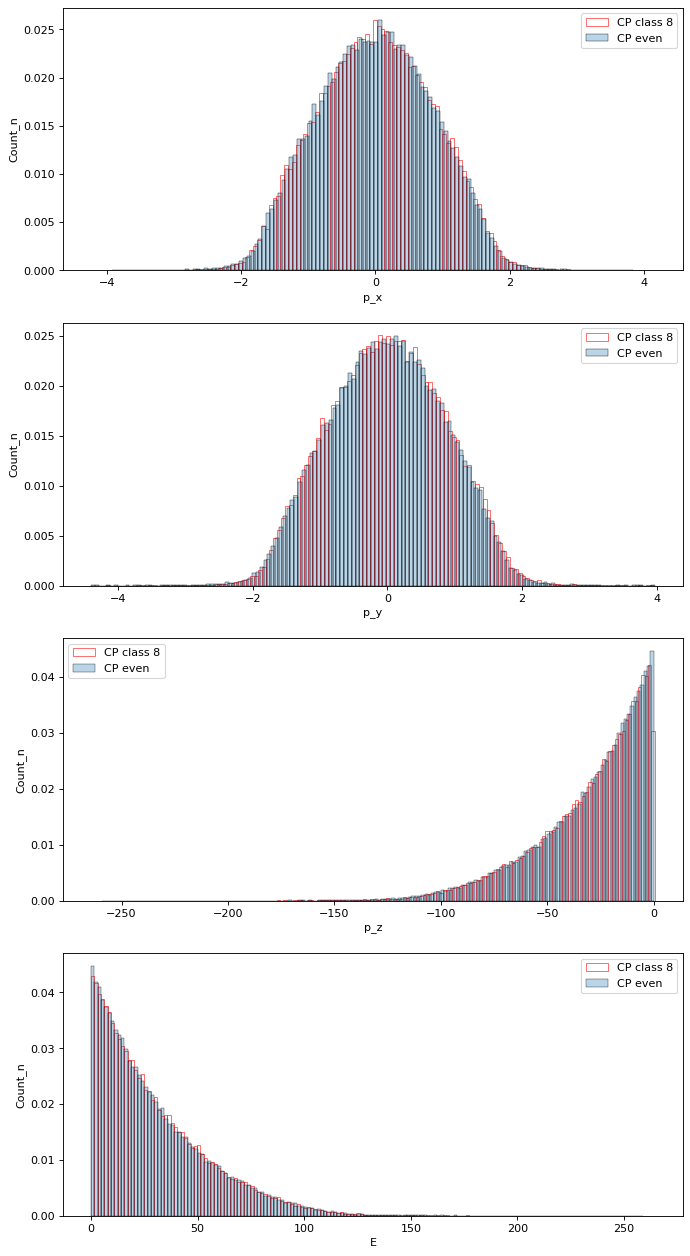

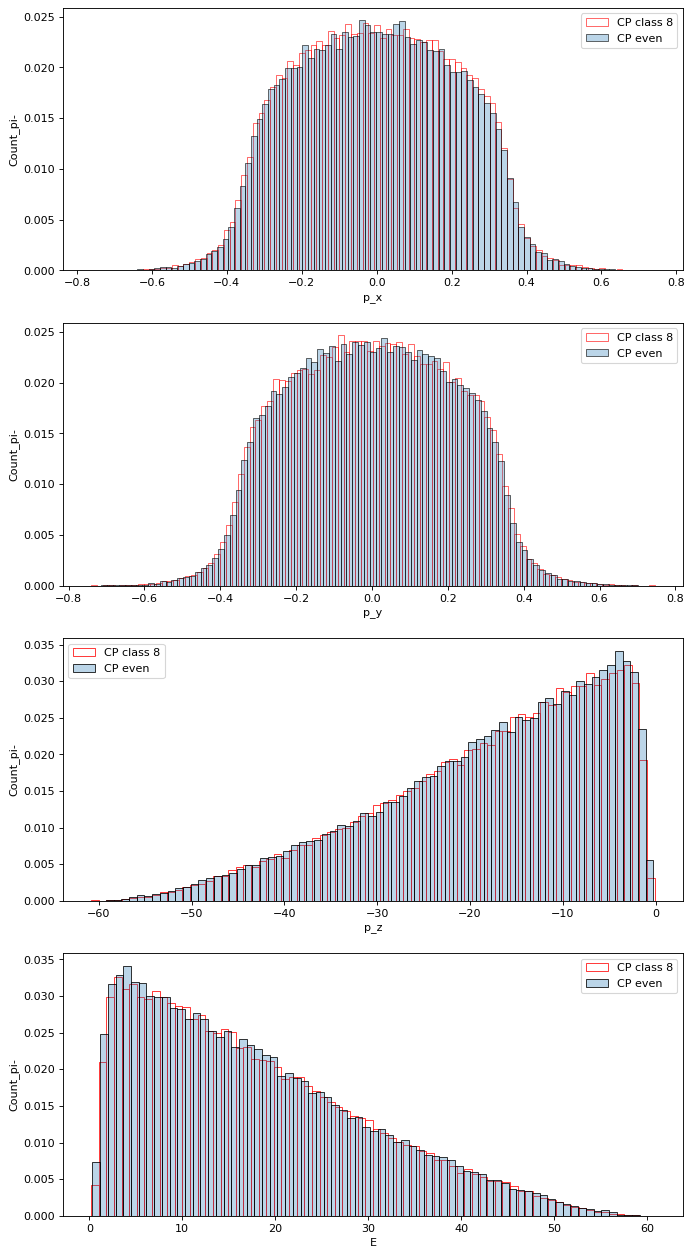

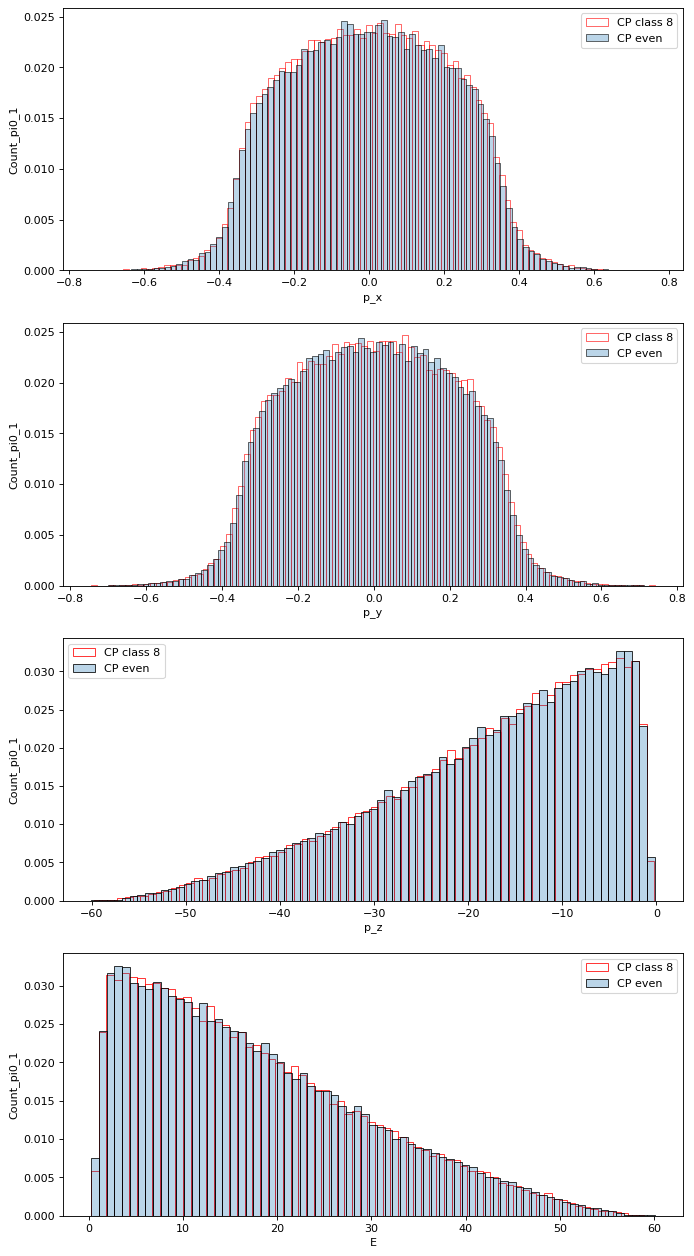

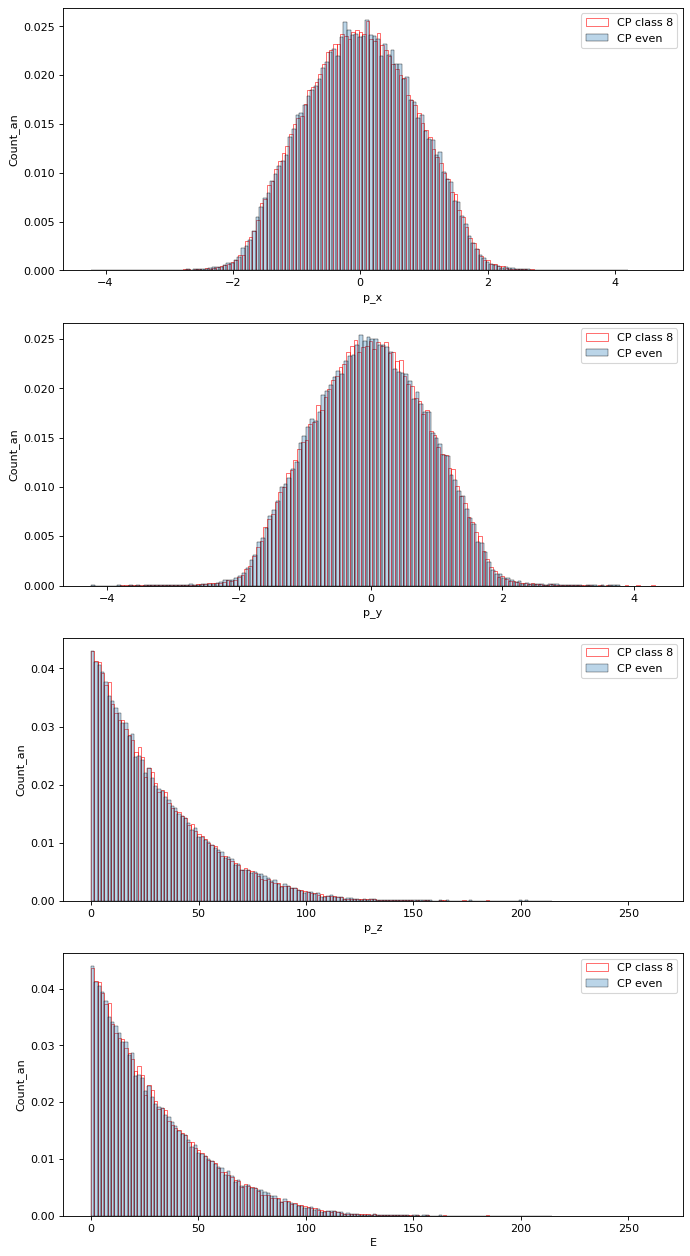

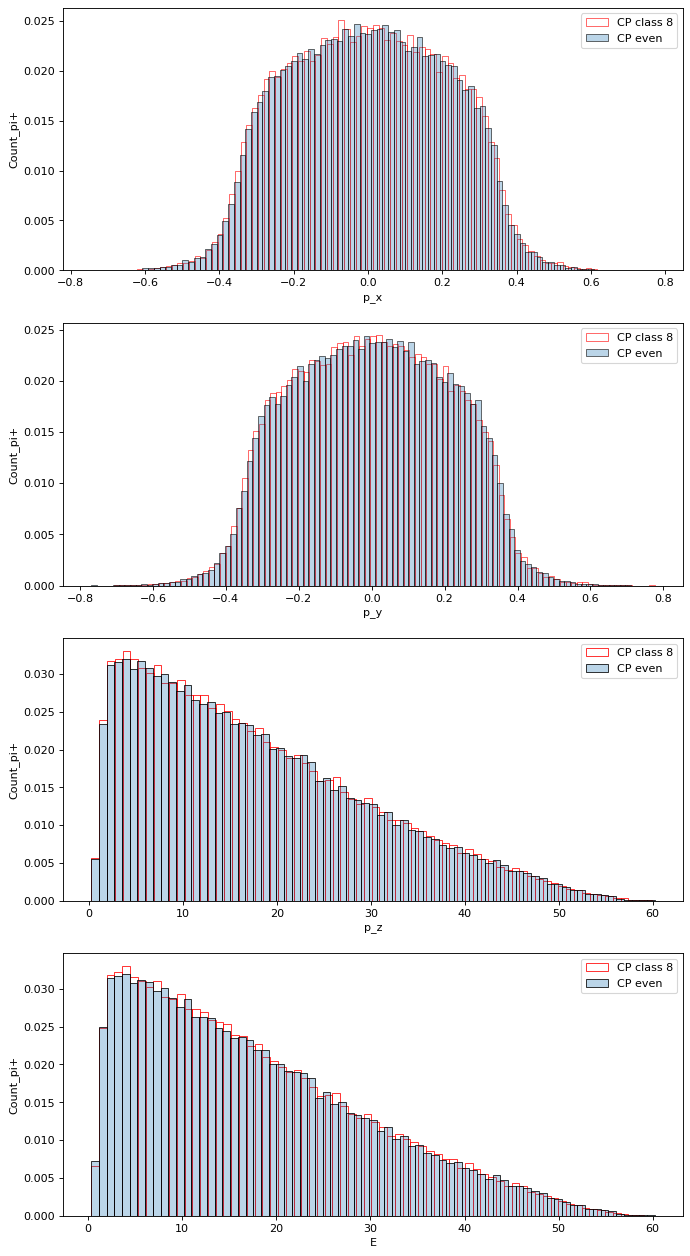

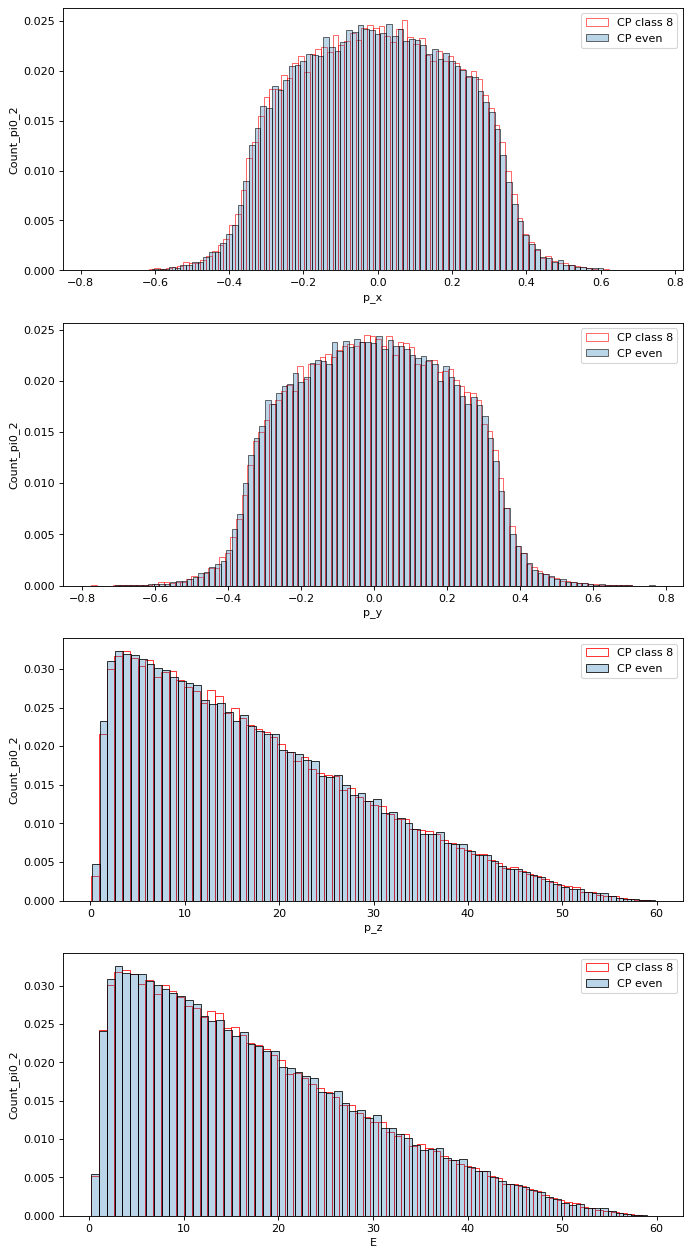

In [12]:
total_distribution_even_eight_p4=[]
for particle in particle_name:
    fig,axis=plt.subplots(4,1,figsize=(10,20),dpi = 80)
    for var, ax in enumerate(axis):
        sns.histplot(data=cp_eight_events_p4[particle], x = cp_eight_events_p4[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP class 8')
#         sns.histplot(data=cp_odd_events_p4[particle], x = cp_odd_events_p4[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP odd')
        sns.histplot(data=cp_even_events_p4[particle], x = cp_even_events_p4[particle].columns[var], ax = ax,stat='probability',alpha=0.3,label='CP even')
        ax.set_ylabel('Count_'+str(particle),fontsize=10)
        ax.legend()
        patches = ax.patches
        middle_idx=int(len(patches)/2)
        dist_1=[patches[i].get_height() for i in range(middle_idx)]
        dist_2=[patches[i].get_height() for i in range(middle_idx,int(len(patches)))]
        total_distribution_even_eight_p4.append([dist_1,dist_2])

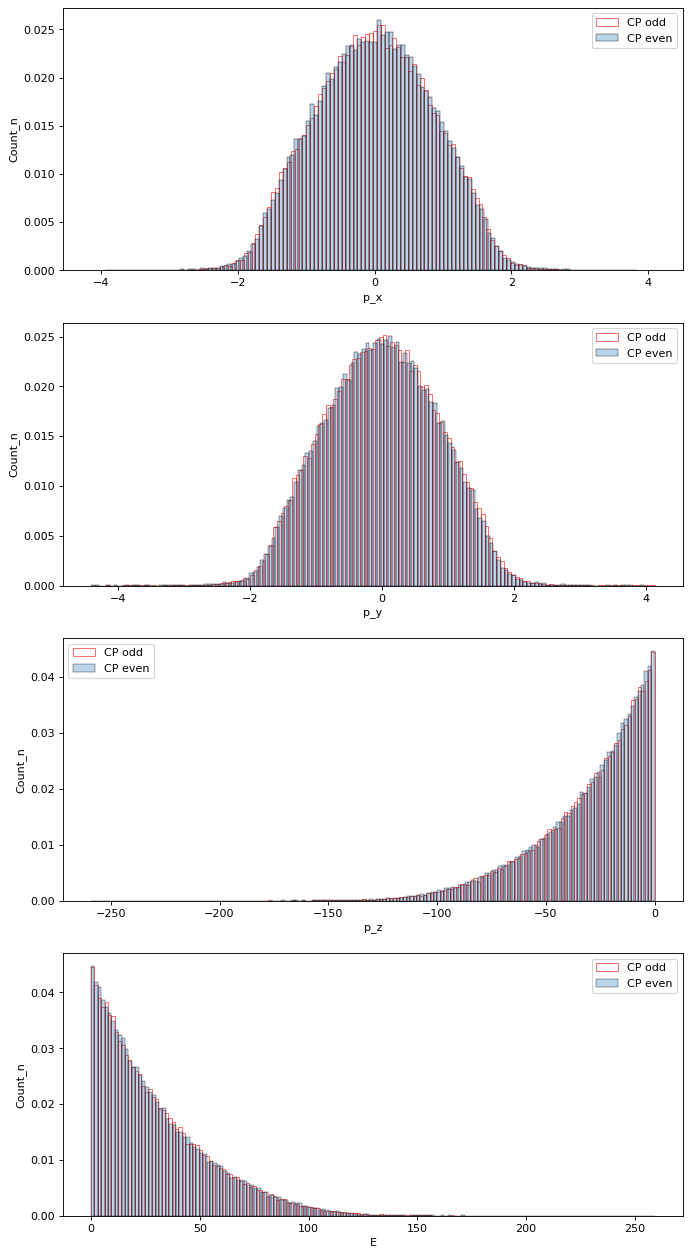

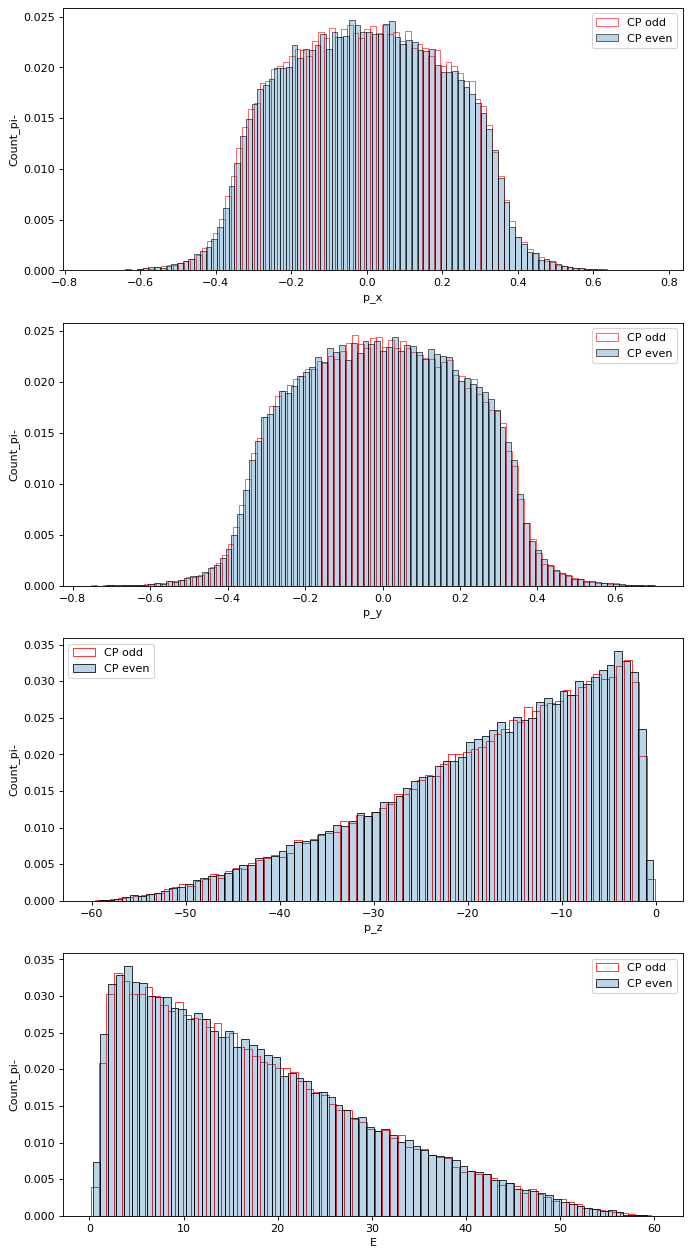

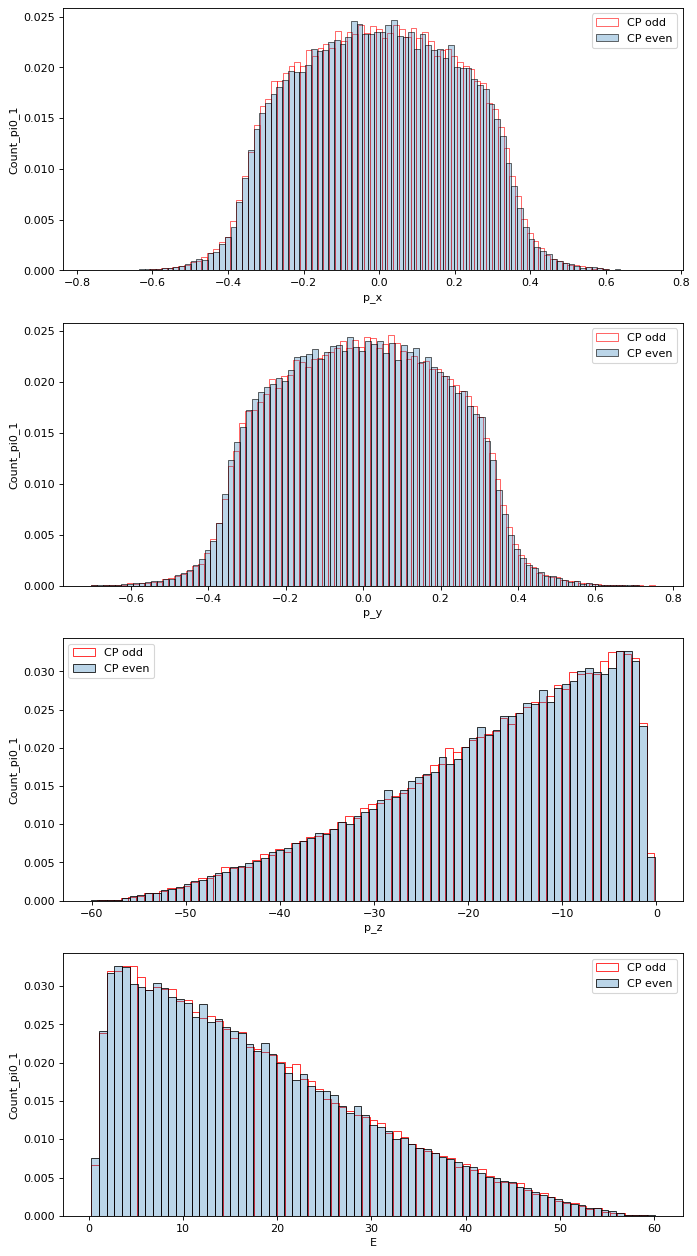

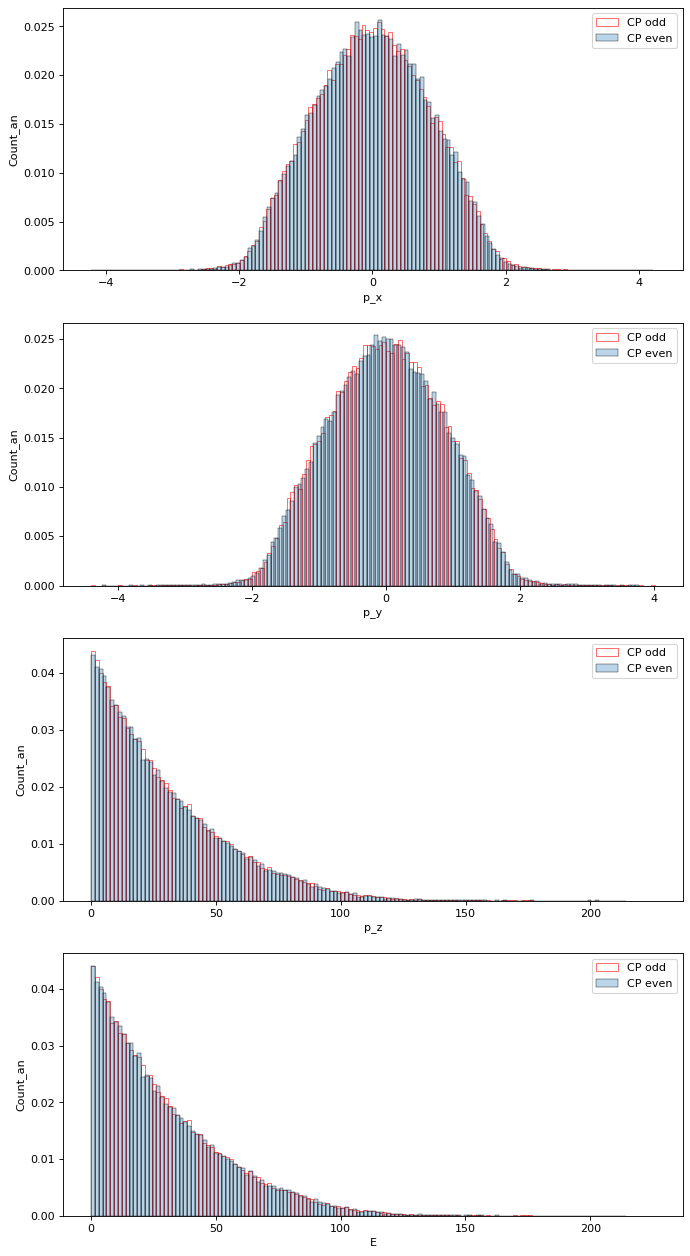

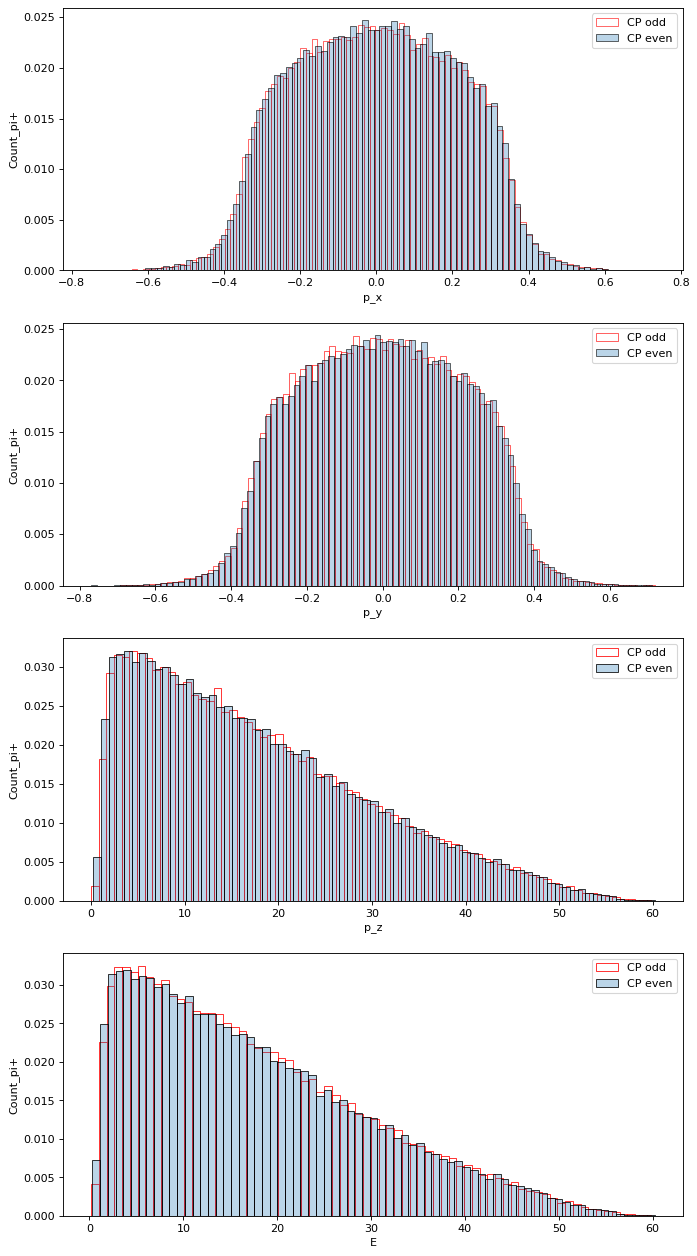

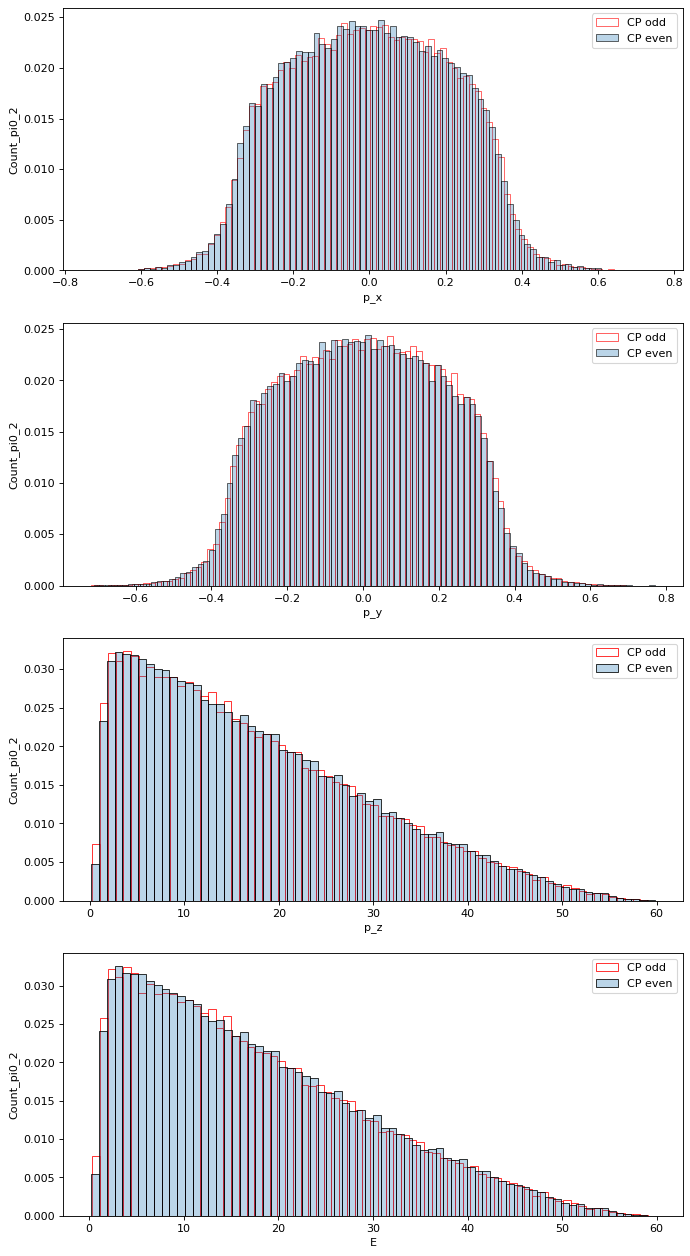

In [13]:
total_distribution_even_odd_p4=[]
for particle in particle_name:
    fig,axis=plt.subplots(4,1,figsize=(10,20),dpi = 80)
    for var, ax in enumerate(axis):
#         sns.histplot(data=cp_eight_events_p4[particle], x = cp_eight_events_p4[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP class 8')
        sns.histplot(data=cp_odd_events_p4[particle], x = cp_odd_events_p4[particle].columns[var], ax = ax,stat='probability',color='red',fill=False,label='CP odd')
        sns.histplot(data=cp_even_events_p4[particle], x = cp_even_events_p4[particle].columns[var], ax = ax,stat='probability',alpha=0.3,label='CP even')
        ax.set_ylabel('Count_'+str(particle),fontsize=10)
        ax.legend()
        patches = ax.patches
        middle_idx=int(len(patches)/2)
        dist_1=[patches[i].get_height() for i in range(middle_idx)]
        dist_2=[patches[i].get_height() for i in range(middle_idx,int(len(patches)))]
        total_distribution_even_odd_p4.append([dist_1,dist_2])

 #### JS Divergence (Calculating the distance between two distributions)

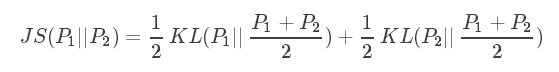

In [14]:
def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

In [15]:
divergence_even_odd_p4=[]
for var_idx in range(len(total_distribution_even_odd_p4)):
    p1=np.array(total_distribution_even_odd_p4[var_idx][0])
    p2=np.array(total_distribution_even_odd_p4[var_idx][1])
    if len(p1)> len(p2):
        p1 = p1[:len(p2)]
    else: 
        p2 = p2[:len(p1)]
    divergence_even_odd_p4.append(JS_divergence(p1,p2))

In [16]:
divergence_even_odd_p4 = np.array(divergence_even_odd_p4)

In [17]:
divergence_even_eight_p4=[]
for var_idx in range(len(total_distribution_even_eight_p4)):
    p1=np.array(total_distribution_even_eight_p4[var_idx][0])
    p2=np.array(total_distribution_even_eight_p4[var_idx][1])
    if len(p1)> len(p2):
        p1 = p1[:len(p2)]
    else: 
        p2 = p2[:len(p1)]
    divergence_even_eight_p4.append(JS_divergence(p1,p2))

In [18]:
divergence_even_eight_p4 = np.array(divergence_even_eight_p4)

In [19]:
var_name = ['p_x', 'p_y', 'p_z', 'E']

In [20]:
feature_name=[ x+'_'+y for x in particle_name for y in var_name]

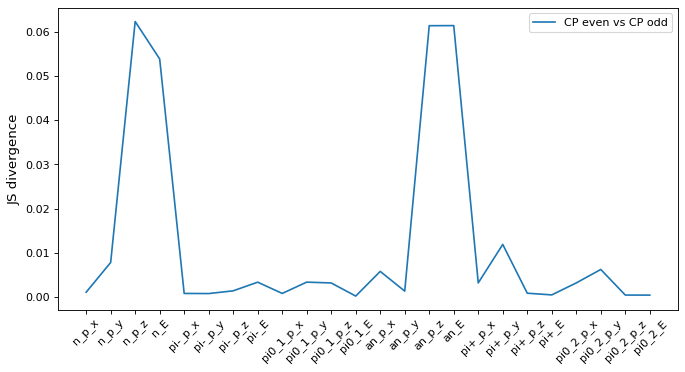

In [21]:
fig_div,ax = plt.subplots(figsize=(10,5),dpi = 80)
# sns.lineplot(data=divergence_even_eight_p4, ax=ax, label= 'CP even vs CP class 8')
sns.lineplot(data=divergence_even_odd_p4, ax=ax, label= 'CP even vs CP odd')
ax.set_xticks(np.arange(0,24))
ax.set_xticklabels(feature_name,rotation=45)
ax.set_ylabel('JS divergence', fontsize = 12)
plt.show()

### p4 2D Distributions (p_x, p_y) after Preprocessing

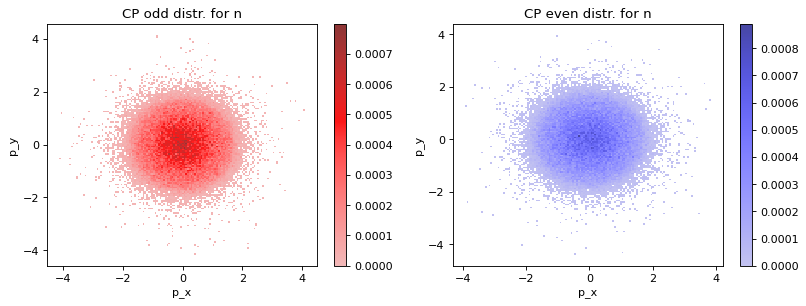

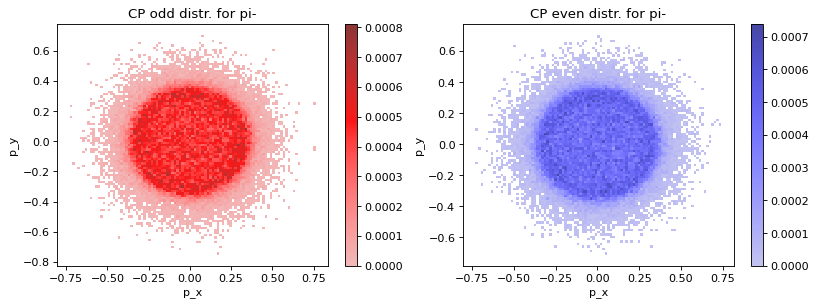

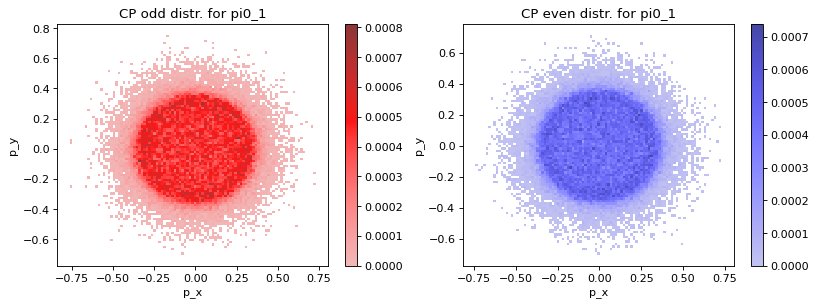

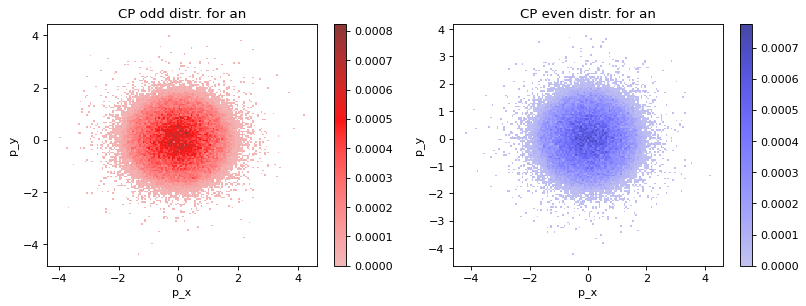

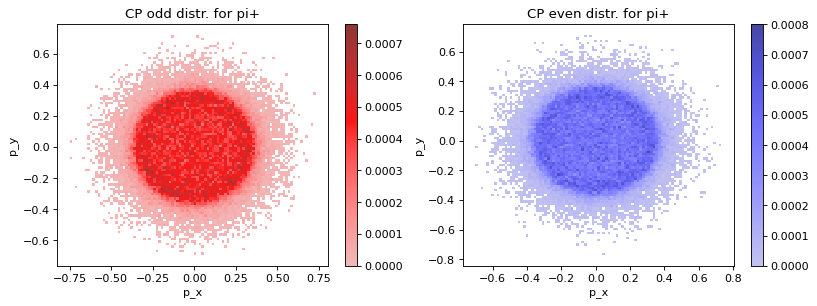

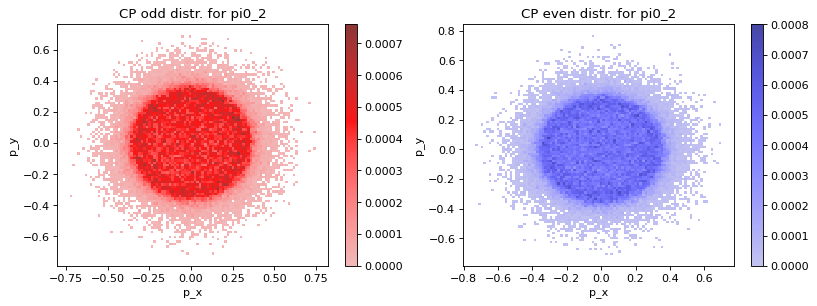

In [22]:
for particle in particle_name:
    fig,axis=plt.subplots(1,2,figsize=(12,4),dpi = 80)
    sns.histplot(cp_odd_events_p4[particle], x = cp_odd_events_p4[particle]['p_x'], y = cp_odd_events_p4[particle]['p_y'], ax = axis[0],stat='probability',cbar=True, color='red',label='CP odd')
    sns.histplot(cp_even_events_p4[particle], x = cp_even_events_p4[particle]['p_x'], y = cp_even_events_p4[particle]['p_y'], ax = axis[1],stat='probability',cbar=True,color='blue',label='CP even')
#     axis[0].set_ylabel('Count_'+str(particle)+'_py',fontsize=10)
#     axis[0].set_xlabel('Count_'+str(particle)+'_px',fontsize=10)
#     axis[1].set_ylabel('Count_'+str(particle)+'_py',fontsize=10)
#     axis[1].set_xlabel('Count_'+str(particle)+'_px',fontsize=10)
    axis[0].set_title('CP odd distr. for '+str(particle))
    axis[1].set_title('CP even distr. for '+str(particle))

### Delta phi distributions after preprocessing

In [23]:
preprocessed_charged_dphi = preprocessed_PtEtaPhi['pi-']['phi']-preprocessed_PtEtaPhi['pi+']['phi']
preprocessed_neutral_dphi = preprocessed_PtEtaPhi['pi0_1']['phi']-preprocessed_PtEtaPhi['pi0_2']['phi']
preprocessed_nutrino_dphi = preprocessed_PtEtaPhi['n']['phi']-preprocessed_PtEtaPhi['an']['phi']

#### Selection of CP odd and CP even events for delta phi variable

In [24]:
cp_even_charged_dphi = preprocessed_charged_dphi.iloc[(np.argmax(points.train.weights,axis=1)==0 )| (np.argmax(points.train.weights,axis=1)==10)]
cp_eight_charged_dphi = preprocessed_charged_dphi.iloc[np.argmax(points.train.weights,axis=1)==8]
cp_odd_charged_dphi = preprocessed_charged_dphi.iloc[np.argmax(points.train.weights,axis=1)==4]

In [25]:
cp_even_neutral_dphi = preprocessed_neutral_dphi.iloc[(np.argmax(points.train.weights,axis=1)==0 )| (np.argmax(points.train.weights,axis=1)==10)]
cp_eight_neutral_dphi = preprocessed_neutral_dphi.iloc[np.argmax(points.train.weights,axis=1)==8]
cp_odd_neutral_dphi = preprocessed_neutral_dphi.iloc[np.argmax(points.train.weights,axis=1)==4]

In [26]:
cp_even_neutrino_dphi = preprocessed_nutrino_dphi.iloc[(np.argmax(points.train.weights,axis=1)==0 )| (np.argmax(points.train.weights,axis=1)==10)]
cp_eight_neutrino_dphi = preprocessed_nutrino_dphi.iloc[np.argmax(points.train.weights,axis=1)==8]
cp_odd_neutrino_dphi = preprocessed_nutrino_dphi.iloc[np.argmax(points.train.weights,axis=1)==4]

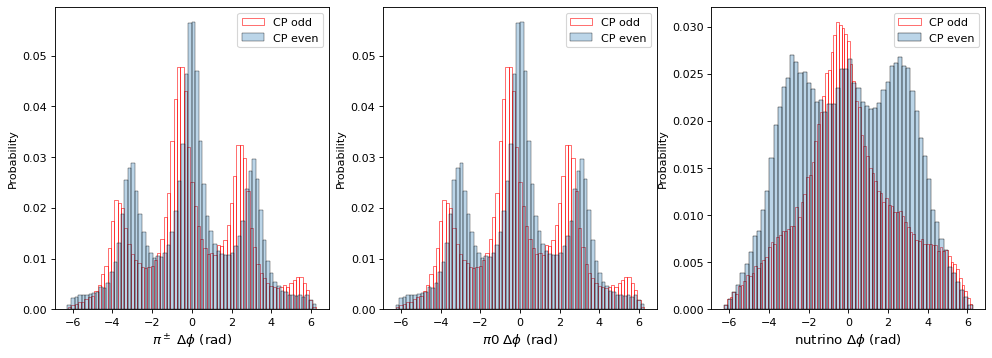

In [27]:
fig,axis=plt.subplots(1,3,figsize=(15,5),dpi = 80)

# sns.histplot(data=cp_eight_charged_dphi, ax = axis[0],stat='probability',color='red',fill=False,label='CP class 8')
sns.histplot(data=cp_odd_charged_dphi, ax = axis[0],stat='probability',color='red',fill=False,label='CP odd')
sns.histplot(data=cp_even_charged_dphi, ax = axis[0],stat='probability',alpha=0.3,label='CP even')

# sns.histplot(data=cp_eight_charged_dphi, ax = axis[1],stat='probability',color='red',fill=False,label='CP class 8')
sns.histplot(data=cp_odd_charged_dphi, ax = axis[1],stat='probability',color='red',fill=False,label='CP odd')
sns.histplot(data=cp_even_charged_dphi, ax = axis[1],stat='probability',alpha=0.3,label='CP even')

# sns.histplot(data=cp_eight_neutrino_dphi, ax = axis[2],stat='probability',color='red',fill=False,label='CP class 8')
sns.histplot(data=cp_odd_neutrino_dphi, ax = axis[2],stat='probability',color='red',fill=False,label='CP odd')
sns.histplot(data=cp_even_neutrino_dphi, ax = axis[2],stat='probability',alpha=0.3,label='CP even')

axis[0].set_xlabel(r"$\pi^\pm$ $\Delta \phi$ (rad)",fontsize=12)
axis[1].set_xlabel(r"$\pi0$ $\Delta \phi$ (rad)",fontsize=12)
axis[2].set_xlabel(r"nutrino $\Delta \phi$ (rad)",fontsize=12)

axis[0].legend()
axis[1].legend()
axis[2].legend()

### Truth PtEtaPhi Distributions vs Truth-matched PtEtaPhi Distributions

In [28]:
particle_PtEtaPhi=pd.read_pickle('PtEtaPhi_data/particle_PtEtaPhi.pk')
particle_PtEtaPhi_reco=pd.read_pickle('PtEtaPhi_data/particle_PtEtaPhi_reco.pk')

In [29]:
PtEtaPhi = [pd.DataFrame(particle_PtEtaPhi[particle].values(),columns=[particle+x for x in ['_pt','_eta','_phi','_E']]) for particle in particle_name]
PtEtaPhi=pd.concat(PtEtaPhi,axis=1)

PtEtaPhi_reco = [pd.DataFrame(particle_PtEtaPhi_reco[particle].values(),columns=[particle+x for x in ['_pt','_eta','_phi','_E']]) for particle in particle_name]
PtEtaPhi_reco=pd.concat(PtEtaPhi_reco,axis=1)

In [30]:
PtEtaPhi

,n_pt,n_eta,n_phi,n_E,pi-_pt,pi-_eta,pi-_phi,pi-_E,pi0_1_pt,pi0_1_eta,...,an_phi,an_E,pi+_pt,pi+_eta,pi+_phi,pi+_E,pi0_2_pt,pi0_2_eta,pi0_2_phi,pi0_2_E
0,5.199149,0.585180,-0.998413,6.115040,15.481587,0.705512,-0.934261,19.497532,4.359225,0.788809,...,1.387150,82.632776,77.090978,2.098101,1.403332,318.900852,11.986482,2.064469,1.418620,47.994043
1,21.915146,-0.733023,-1.937749,28.071309,11.809175,-0.733382,-1.909015,15.130515,48.011307,-0.749900,...,0.696751,6.726172,25.948106,-1.083394,0.805942,42.725549,18.719124,-1.115204,0.792876,31.617250
2,51.520297,-2.883713,0.211057,462.046248,9.346855,-2.934152,0.204161,88.134991,1.103943,-2.942377,...,-2.921923,127.978771,5.304270,-2.940359,-3.018930,50.325729,43.475940,-2.907549,-2.963011,399.249914
3,9.385121,0.571347,-1.241022,10.959081,56.758099,0.590553,-1.305594,66.946520,2.532653,0.578015,...,1.804493,39.450130,4.914160,-0.165330,1.849175,4.983430,6.578565,-0.052820,1.767299,6.589126
4,27.482593,0.873144,-1.185102,38.641405,4.921999,0.762941,-1.132543,6.426857,11.188110,0.838353,...,-3.046361,54.531174,11.204625,0.922273,-3.021367,16.317970,86.915133,0.917406,-3.040436,126.128895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,16.512391,-3.559528,-3.129597,290.412265,0.796939,-3.656931,-2.843119,15.448528,5.294012,-3.603389,...,0.462306,32.479919,9.889939,-1.129382,0.473428,16.897427,22.912195,-1.178938,0.461460,40.767037
999996,35.643087,-0.141655,1.399318,36.001299,5.556800,-0.214614,1.429155,5.686975,14.377128,-0.124295,...,-2.608737,31.946517,10.889389,-0.050153,-2.596011,10.903981,41.749596,-0.065221,-2.566687,41.838643
999997,1.182243,-0.708714,-3.124027,1.491820,16.438079,-0.905914,3.043596,23.657811,33.887518,-0.884286,...,-0.427057,127.010783,6.012449,-1.887420,-0.433866,20.303835,16.777457,-1.949429,-0.432009,60.122425
999998,2.190450,1.195776,-1.110353,3.952232,31.705257,1.132515,-0.946170,54.306098,7.949139,1.163427,...,1.314041,31.405513,2.582408,-0.741619,1.256045,3.328649,19.000191,-0.791591,1.261862,25.270880


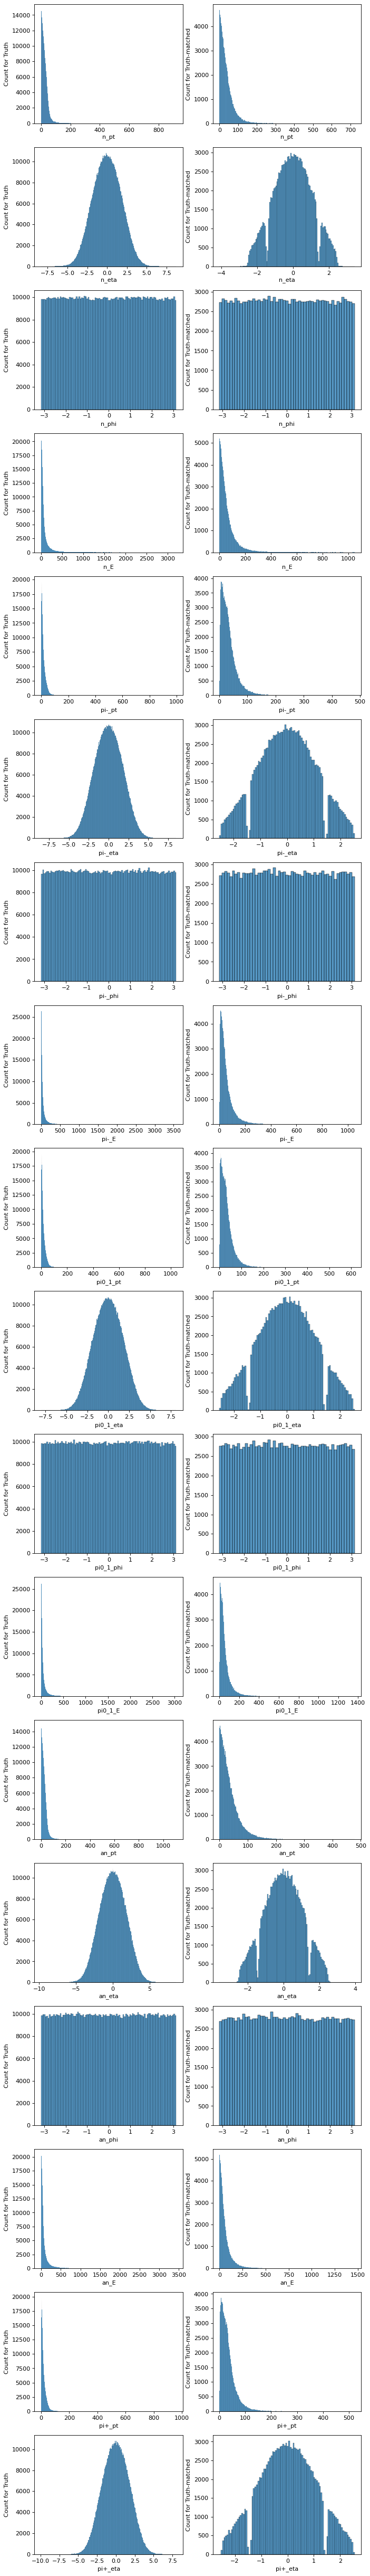

In [31]:
fig,axis=plt.subplots(18,2,figsize=(10,80),dpi = 80)
for i, ax in enumerate(axis):
    sns.histplot(data=PtEtaPhi, x = PtEtaPhi.columns[i], ax = ax[0])
    sns.histplot(data=PtEtaPhi_reco, x = PtEtaPhi_reco.columns[i], ax = ax[1])
    ax[0].set_ylabel('Count for Truth',fontsize=10)
    ax[1].set_ylabel('Count for Truth-matched',fontsize=10)

### Input p4 Distributions

In [33]:
rhorho_raw_H = np.load("HiggsCP_data/rhorho/rhorho_raw.data.npy")
rhorho_raw_Z = np.load("HiggsCP_data/rhorho/rhorhoZ_raw.data.npy")
df_rhorho_raw_H = pd.DataFrame(rhorho_raw_H)
df_rhorho_raw_Z = pd.DataFrame(rhorho_raw_Z)

In [34]:
rhorho_reco_H = np.load("HiggsCP_data/rhorho/rhorho_raw_recon/rhorho_raw.data.npy")
df_rhorho_reco_H = pd.DataFrame(rhorho_reco_H)

In [35]:
for i in range(4,30,5):
    df_rhorho_raw_H.drop(columns=i, inplace=True)
    df_rhorho_raw_Z.drop(columns=i, inplace=True)
    df_rhorho_reco_H.drop(columns=i, inplace=True)

In [36]:
df_rhorho_raw_H.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_rhorho_raw_Z.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_rhorho_reco_H.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])

In [37]:
df_rhorho_H_sampled = df_rhorho_raw_H.sample(n=df_rhorho_reco_H.shape[0], replace=False, axis=0)

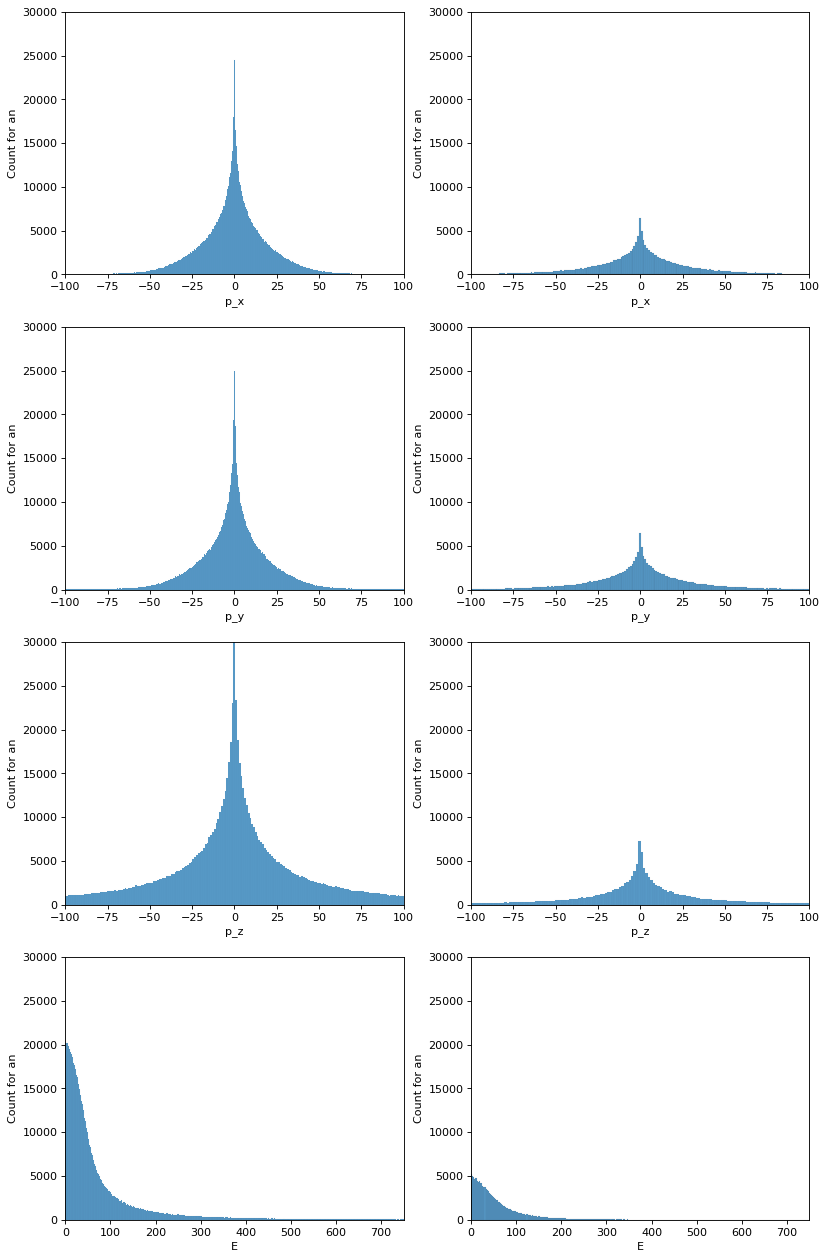

In [38]:
fig,ax=plt.subplots(4,2,figsize=(12,20),dpi = 80)
# for idx,name in enumerate(particle_name):   
# for hor_posi in range(3):
#     sns.scatterplot(data=df_rhorho_H[('pi-')], x=df_rhorho_H[('pi-')].columns[hor_posi],ax = ax[hor_posi])
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df_rhorho_raw_H[('an')], x='p_x', ax = ax[0,0])
sns.histplot(data=df_rhorho_raw_H[('an')], x='p_y', ax = ax[1,0])
sns.histplot(data=df_rhorho_raw_H[('an')], x='p_z', ax = ax[2,0])
sns.histplot(data=df_rhorho_raw_H[('an')], x='E', ax = ax[3,0])
sns.histplot(data=df_rhorho_reco_H[('an')], x='p_x', ax = ax[0,1])
sns.histplot(data=df_rhorho_reco_H[('an')], x='p_y', ax = ax[1,1])
sns.histplot(data=df_rhorho_reco_H[('an')], x='p_z', ax = ax[2,1])
sns.histplot(data=df_rhorho_reco_H[('an')], x='E', ax = ax[3,1])
# sns.histplot(data=df_rhorho_H[('pi+')], x='p_z', ax = ax[0,1])
# sns.histplot(data=df_rhorho_H[('pi+')], x='E', ax = ax[1,1])
ax[0,0].set_xlim((-100, 100))
ax[1,0].set_xlim((-100, 100))
ax[2,0].set_xlim((-100, 100))
ax[3,0].set_xlim((0, 750))
ax[0,1].set_xlim((-100, 100))
ax[1,1].set_xlim((-100, 100))
ax[2,1].set_xlim((-100, 100))
ax[3,1].set_xlim((0, 750))
for axis in ax:
    for axiss in axis:
        axiss.set_ylabel('Count for an',fontsize=10)
        axiss.set_ylim((0, 30000))

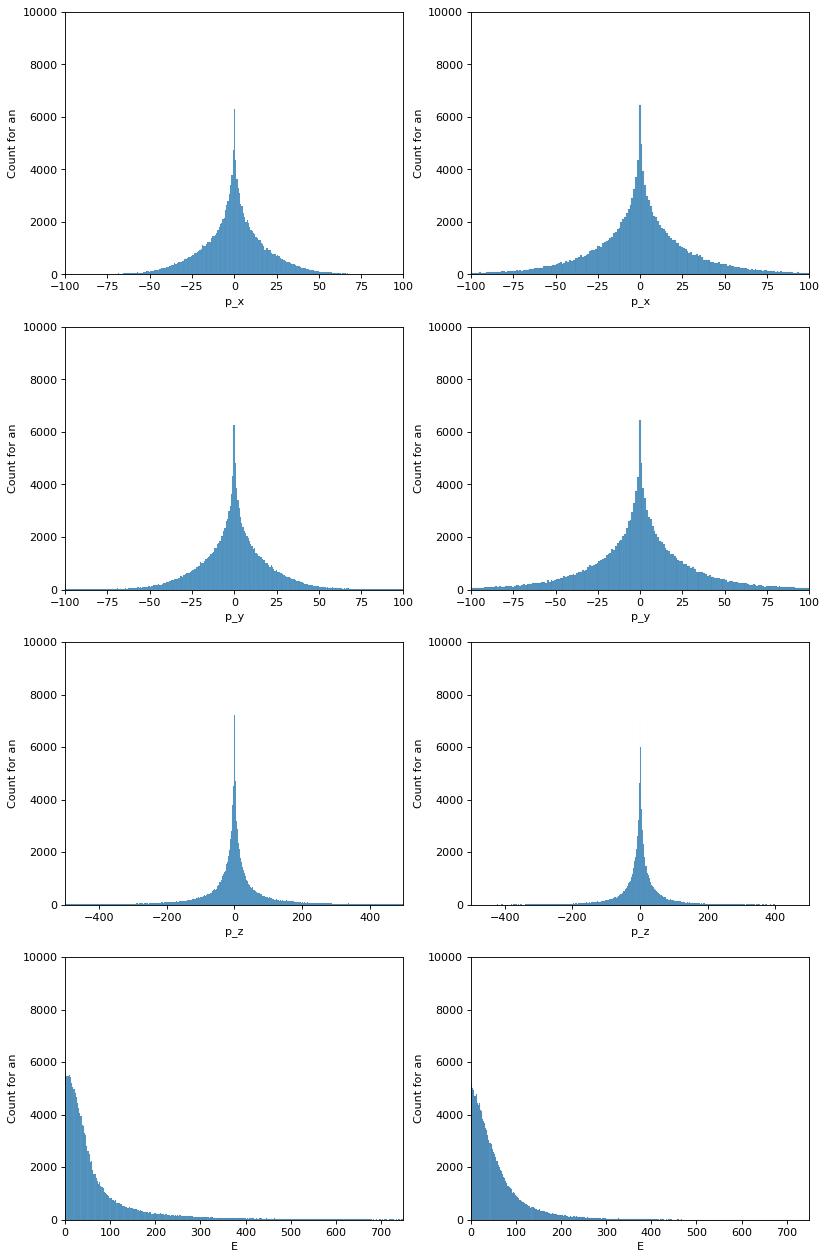

In [39]:
fig,ax=plt.subplots(4,2,figsize=(12,20),dpi = 80)
# for idx,name in enumerate(particle_name):   
# for hor_posi in range(3):
#     sns.scatterplot(data=df_rhorho_H[('pi-')], x=df_rhorho_H[('pi-')].columns[hor_posi],ax = ax[hor_posi])
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data=df_rhorho_H_sampled[('an')], x='p_x', ax = ax[0,0])
sns.histplot(data=df_rhorho_H_sampled[('an')], x='p_y', ax = ax[1,0])
sns.histplot(data=df_rhorho_H_sampled[('an')], x='p_z', ax = ax[2,0])
sns.histplot(data=df_rhorho_H_sampled[('an')], x='E', ax = ax[3,0])
sns.histplot(data=df_rhorho_reco_H[('an')], x='p_x', ax = ax[0,1])
sns.histplot(data=df_rhorho_reco_H[('an')], x='p_y', ax = ax[1,1])
sns.histplot(data=df_rhorho_reco_H[('an')], x='p_z', ax = ax[2,1])
sns.histplot(data=df_rhorho_reco_H[('an')], x='E', ax = ax[3,1])
# sns.histplot(data=df_rhorho_H[('pi+')], x='p_z', ax = ax[0,1])
# sns.histplot(data=df_rhorho_H[('pi+')], x='E', ax = ax[1,1])
ax[0,0].set_xlim((-100, 100))
ax[1,0].set_xlim((-100, 100))
ax[2,0].set_xlim((-500, 500))
ax[3,0].set_xlim((0, 750))
ax[0,1].set_xlim((-100, 100))
ax[1,1].set_xlim((-100, 100))
ax[2,1].set_xlim((-500, 500))
ax[3,1].set_xlim((0, 750))
for axis in ax:
    for axiss in axis:
        axiss.set_ylabel('Count for an',fontsize=10)
        axiss.set_ylim((0, 10000))

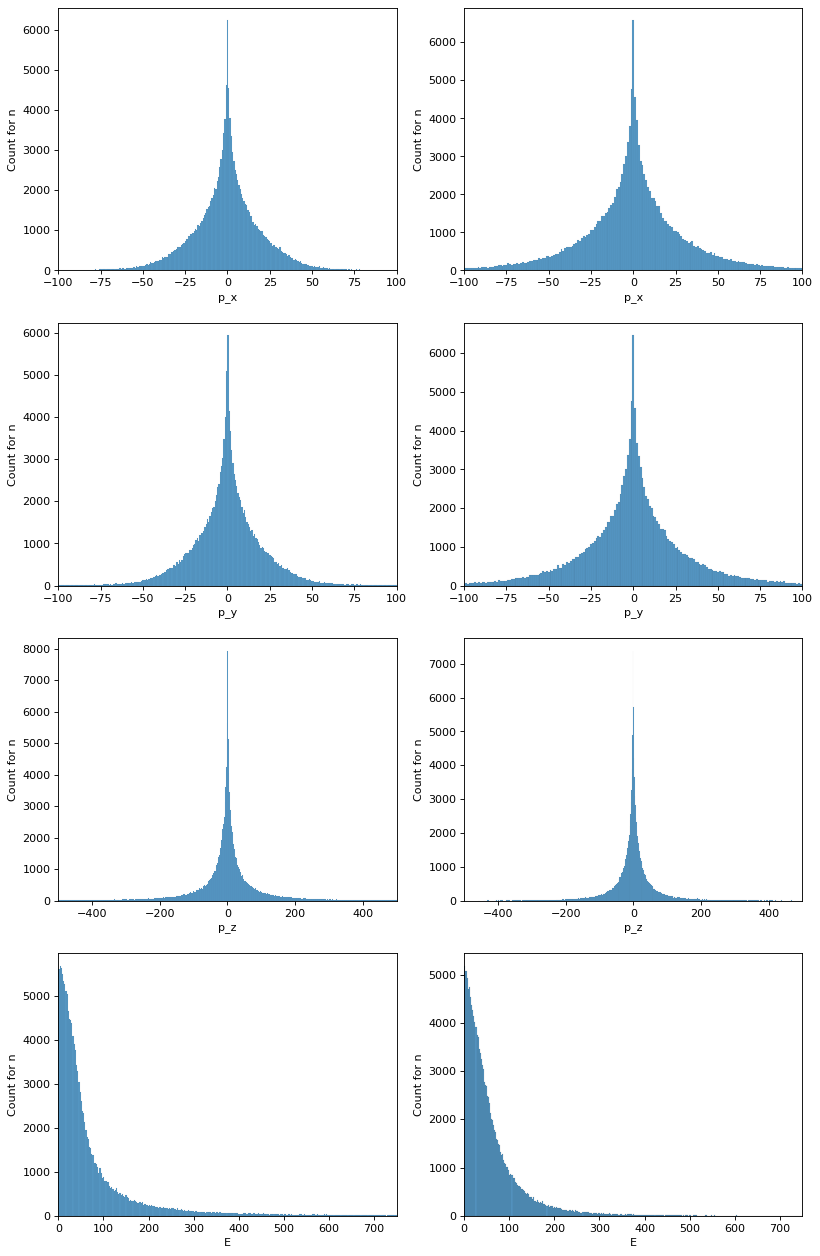

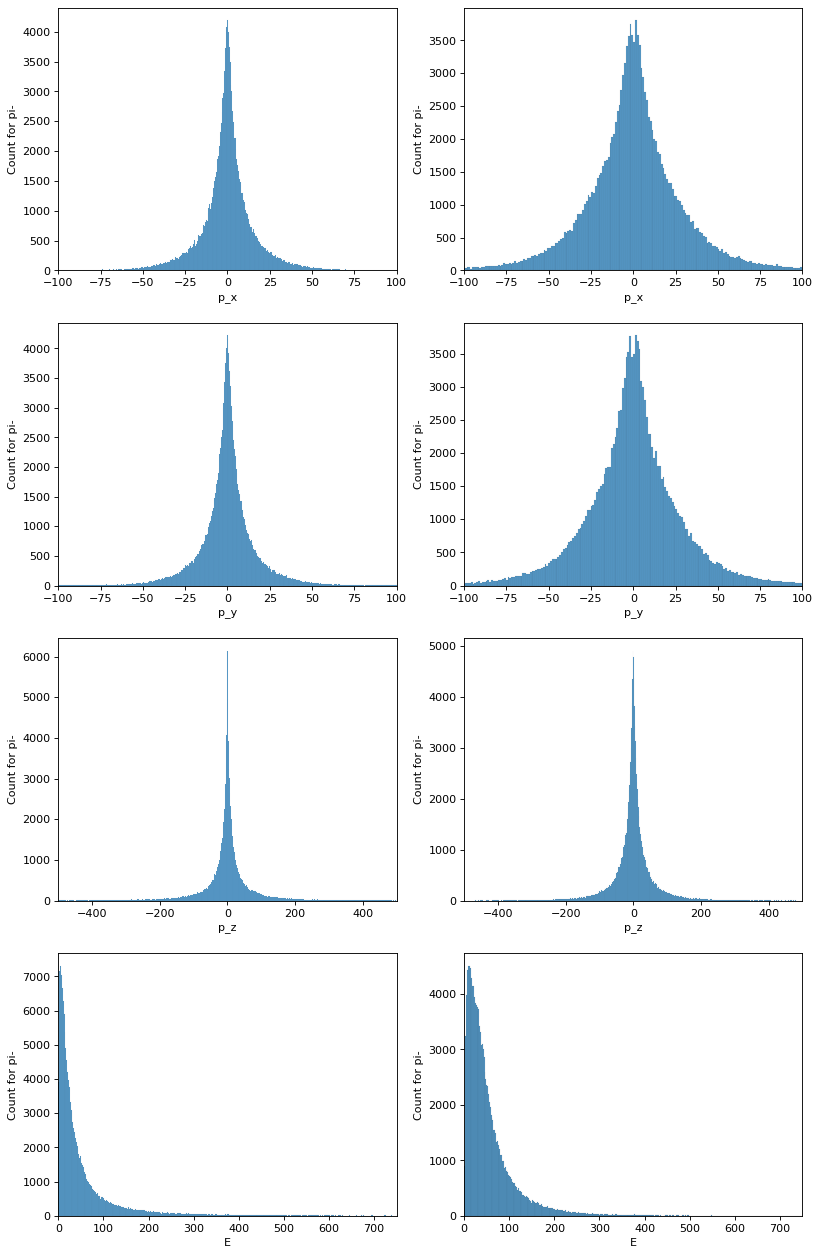

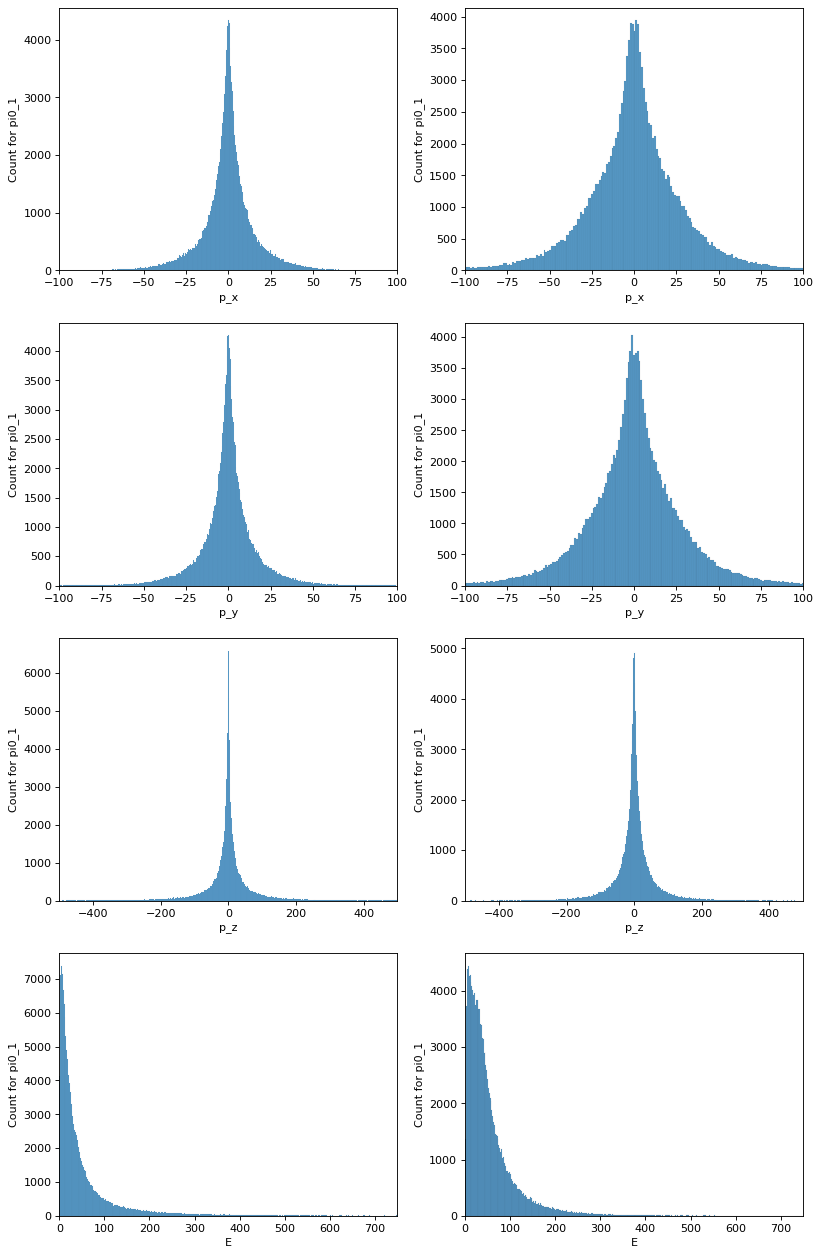

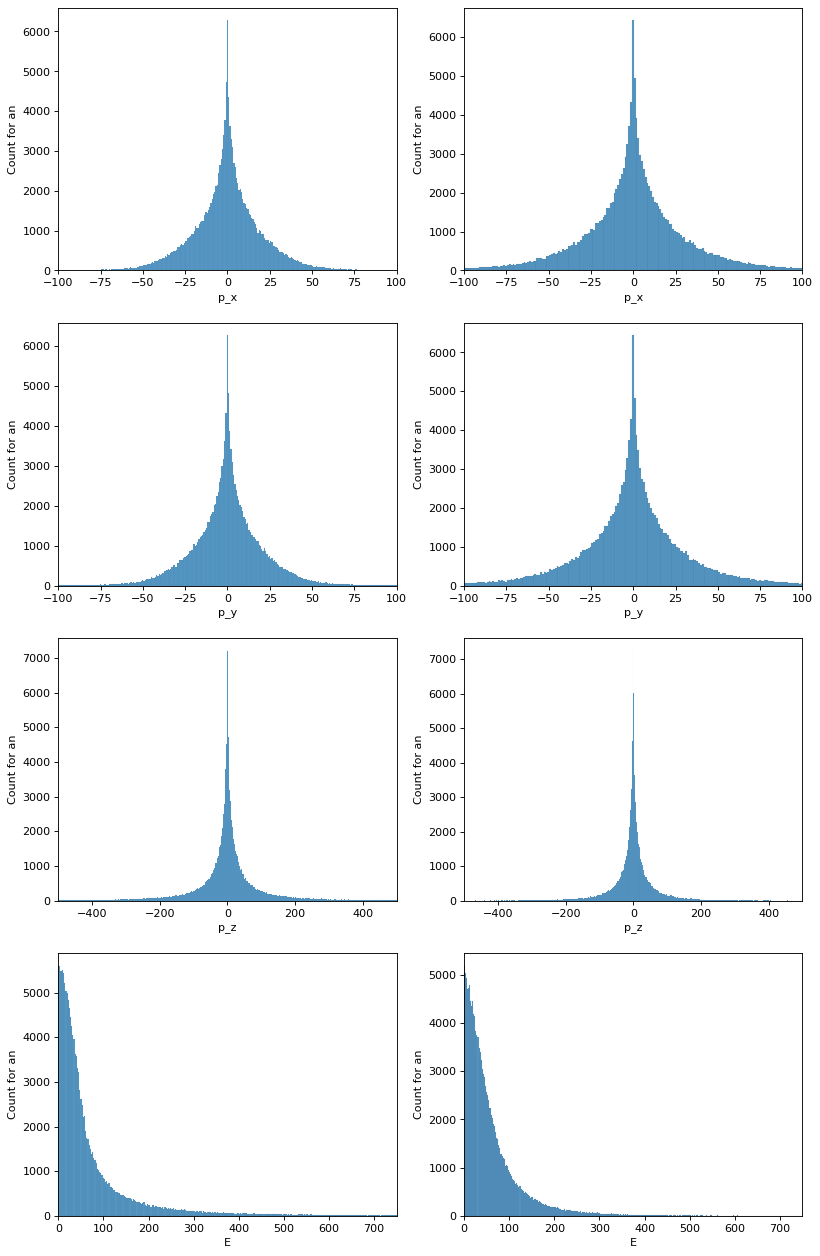

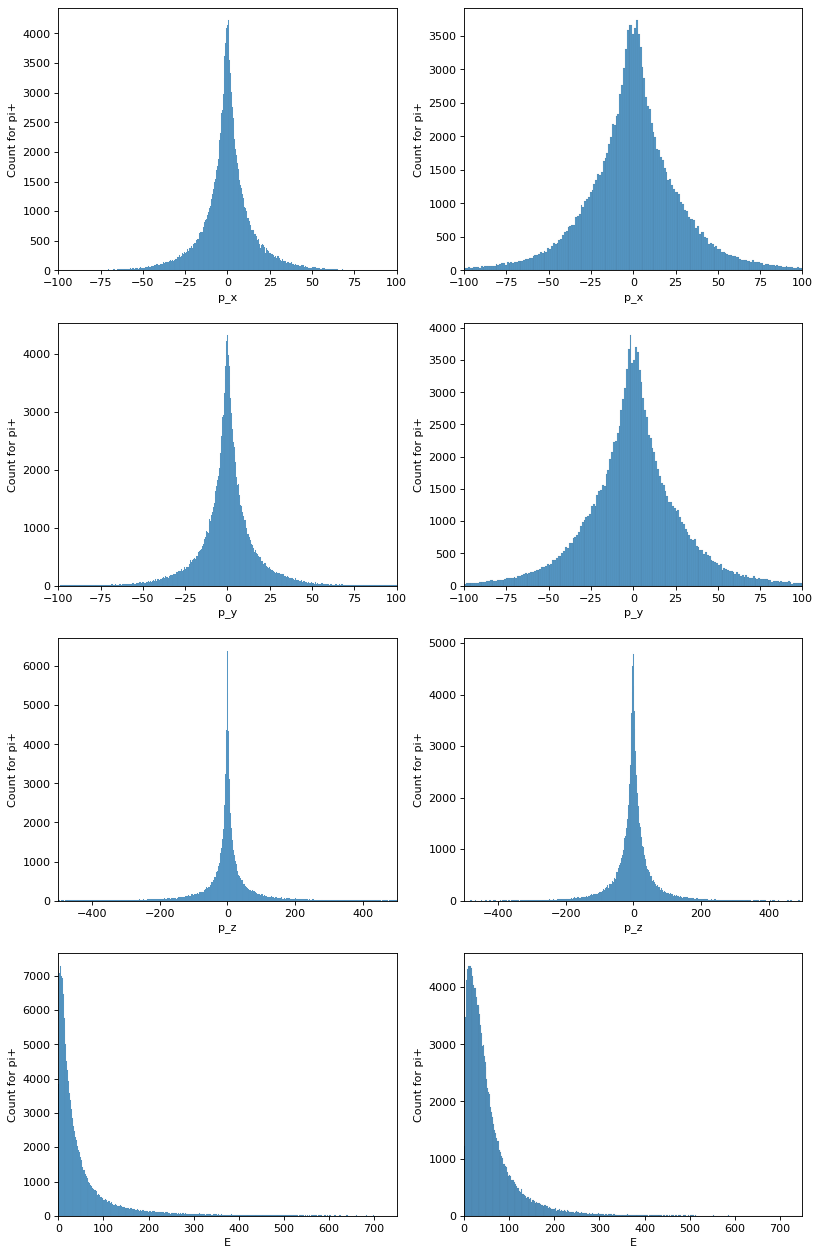

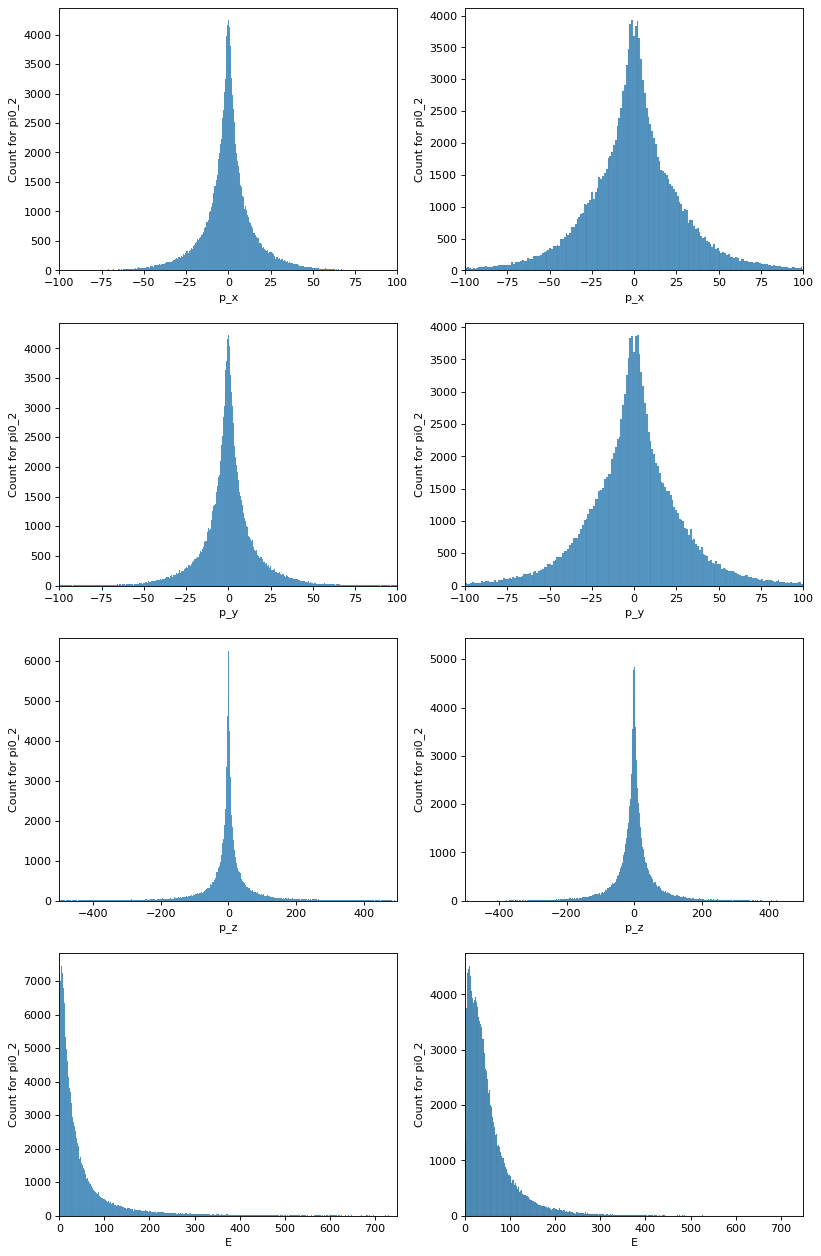

In [40]:
for particle in particle_name:
    fig,ax=plt.subplots(4,2,figsize=(12,20),dpi = 80)
    # for idx,name in enumerate(particle_name):   
    # for hor_posi in range(3):
    #     sns.scatterplot(data=df_rhorho_H[('pi-')], x=df_rhorho_H[('pi-')].columns[hor_posi],ax = ax[hor_posi])
    # sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.histplot(data=df_rhorho_H_sampled[(particle)], x='p_x', ax = ax[0,0])
    sns.histplot(data=df_rhorho_H_sampled[(particle)], x='p_y', ax = ax[1,0])
    sns.histplot(data=df_rhorho_H_sampled[(particle)], x='p_z', ax = ax[2,0])
    sns.histplot(data=df_rhorho_H_sampled[(particle)], x='E', ax = ax[3,0])
    sns.histplot(data=df_rhorho_reco_H[(particle)], x='p_x', ax = ax[0,1])
    sns.histplot(data=df_rhorho_reco_H[(particle)], x='p_y', ax = ax[1,1])
    sns.histplot(data=df_rhorho_reco_H[(particle)], x='p_z', ax = ax[2,1])
    sns.histplot(data=df_rhorho_reco_H[(particle)], x='E', ax = ax[3,1])
    # sns.histplot(data=df_rhorho_H[('pi+')], x='p_z', ax = ax[0,1])
    # sns.histplot(data=df_rhorho_H[('pi+')], x='E', ax = ax[1,1])
    ax[0,0].set_xlim((-100, 100))
    ax[1,0].set_xlim((-100, 100))
    ax[2,0].set_xlim((-500, 500))
    ax[3,0].set_xlim((0, 750))
    ax[0,1].set_xlim((-100, 100))
    ax[1,1].set_xlim((-100, 100))
    ax[2,1].set_xlim((-500, 500))
    ax[3,1].set_xlim((0, 750))
        
    ax[0,0].set_ylabel('Count for '+ particle,fontsize=10)
    ax[1,0].set_ylabel('Count for '+ particle,fontsize=10)
    ax[2,0].set_ylabel('Count for '+ particle,fontsize=10)
    ax[3,0].set_ylabel('Count for '+ particle,fontsize=10)
    ax[0,1].set_ylabel('Count for '+ particle,fontsize=10)
    ax[1,1].set_ylabel('Count for '+ particle,fontsize=10)
    ax[2,1].set_ylabel('Count for '+ particle,fontsize=10)
    ax[3,1].set_ylabel('Count for '+ particle,fontsize=10)

### Correlations

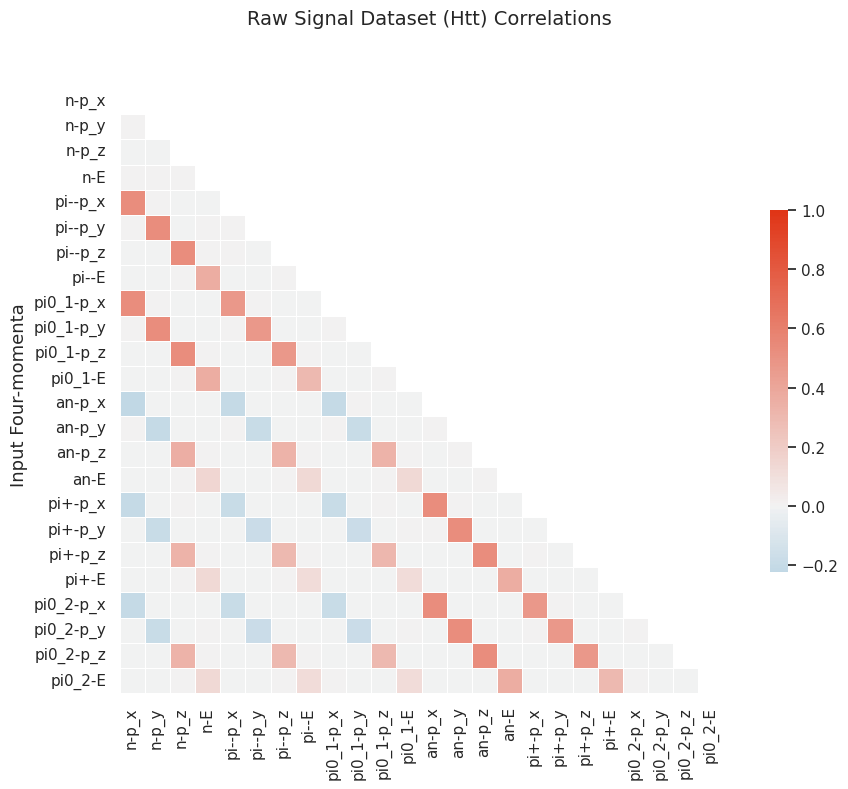

In [41]:
def corre_plot(df, figtitle='', ax_lable = ''):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8), dpi=100)
    f.suptitle(figtitle, fontsize=14)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 15, as_cmap=True, s=95, l=50)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .6})
    ax.set_ylabel(ax_lable,fontsize=13)
    ax.set_xlabel('')
    
    return

corre_plot(df_rhorho_raw_H, figtitle='Raw Signal Dataset (Htt) Correlations', ax_lable= 'Input Four-momenta ')

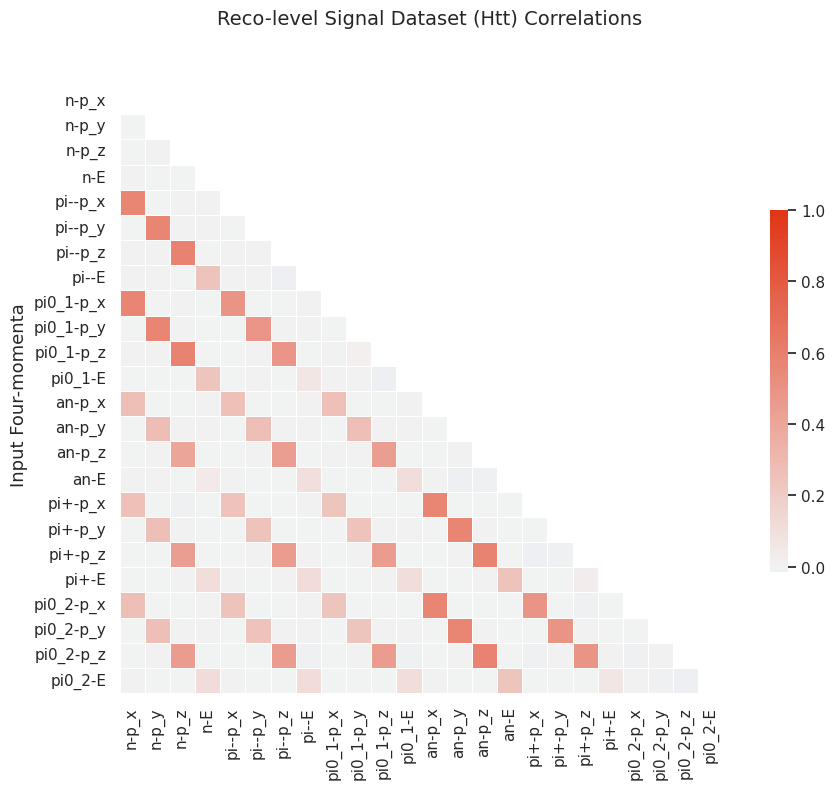

In [42]:
corre_plot(df_rhorho_reco_H, figtitle='Reco-level Signal Dataset (Htt) Correlations', ax_lable= 'Input Four-momenta ')

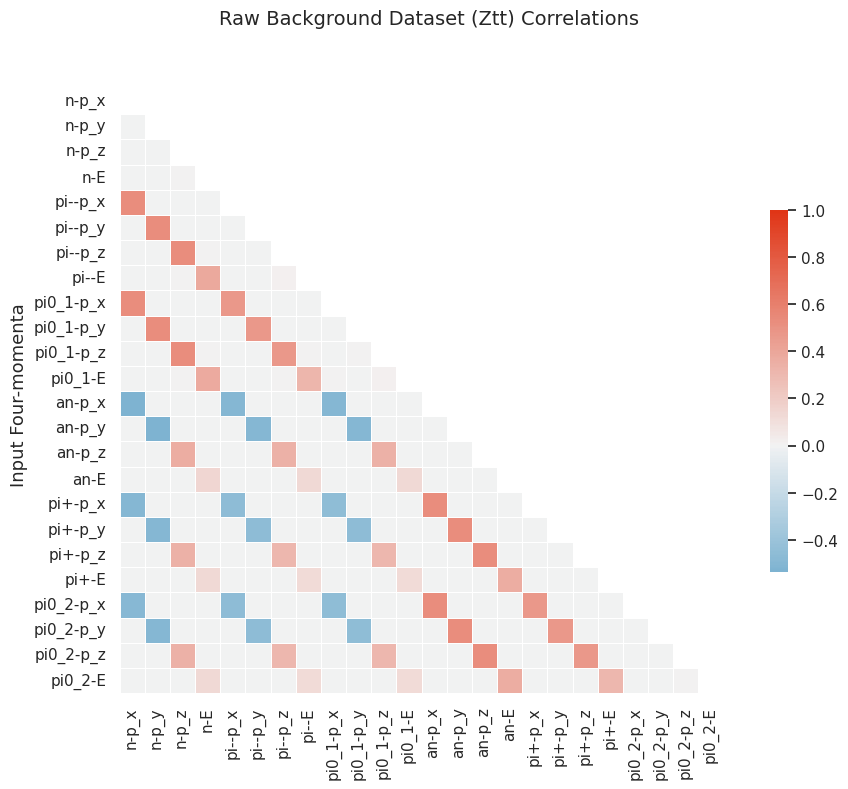

In [43]:
corre_plot(df_rhorho_raw_Z, figtitle='Raw Background Dataset (Ztt) Correlations', ax_lable= 'Input Four-momenta ')

## Preprocessed Dataset Visualization

In [44]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import train_rhorho, train_a1rho, train_a1a1

types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

decaymodes = ['rhorho', 'a1rho', 'a1a1']
decaymode = decaymodes[0]  ###### Change this to corresponding decaymode ############

parser.add_argument("-i", "--input", dest="IN", default='HiggsCP_data/'+ decaymode)
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_'+ decaymode)
args, unknown = parser.parse_known_args()

Instructions for updating:
non-resource variables are not supported in the long term


In [45]:
points_S=pickle.load(open(args.IN+'/events_wo_background.pk','rb'))

In [46]:
df_rhorho_H_process = pd.DataFrame(points_S.train.x)
df_rhorho_H_process.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_rhorho_H_process

n                                     pi-                      \
             p_x       p_y       p_z         E       p_x       p_y       p_z   
0      -1.953867  0.357369 -1.277533  1.277548 -0.440212 -0.242485 -0.613024   
1      -1.662156 -1.472997 -1.466149  1.466343  0.324299  1.131436  1.135841   
2      -0.449850 -0.629947  0.890092 -0.890138  1.233387  1.100997 -0.172728   
3      -0.095853 -0.983347  0.185073 -0.185654  0.802620  1.249176  1.000444   
4       0.449746 -0.649203  0.815408 -0.815659  0.982248 -1.646700 -0.920879   
...          ...       ...       ...       ...       ...       ...       ...   
799995  0.000594 -1.022520 -0.108831  0.108202  0.068875 -2.546244 -0.115295   
799996 -1.417964  0.587337 -0.383732  0.383540 -1.581386  0.832556 -0.184918   
799997  1.303216  1.834320 -1.014374  1.014742  1.264215  0.792430  0.548497   
799998  0.168436  0.290312  1.031745 -1.032564 -0.046437  1.290368  1.165313   
799999  1.769886 -0.075424  0.027152 -0.026721 -1.047735 -0.279464 -0.154847   

                     pi0_1            ...        an                 pi+  \
               E       p_x       p_y  ...       p_z         E       p_x   
0       0.612808  0.440212  0.242485  ... -0.853767 -0.853353  0.020188   
1      -1.135661 -0.324299 -1.131436  ... -0.049962 -0.048820 -0.651734   
2       0.172653 -1.233387 -1.100997  ...  0.475966  0.475681  1.930292   
3      -1.000217 -0.802620 -1.249176  ... -1.050310 -1.050756 -0.988163   
4       0.920941 -0.982248  1.646700  ...  0.186252  0.186314 -0.598638   
...          ...       ...       ...  ...       ...       ...       ...   
799995  0.115572 -0.068875  2.546244  ... -0.708370 -0.708439 -0.050039   
799996  0.184886  1.581386 -0.832556  ... -1.107022 -1.107166 -1.550734   
799997 -0.548590 -1.264215 -0.792430  ...  0.168843  0.168453 -1.490412   
799998 -1.164912  0.046437 -1.290368  ... -1.075644 -1.075967 -0.587692   
799999  0.154628  1.047735  0.279464  ...  0.909992  0.910294 -1.408343   

                                         pi0_2                                
             p_y       p_z         E       p_x       p_y       p_z         E  
0      -0.813614 -1.290212 -1.289926 -0.020188  0.813614  0.569592  0.569398  
1       1.068381 -1.057960 -1.057858  0.651734 -1.068381 -0.415814 -0.416026  
2       0.231456  0.662396  0.662437 -1.930292 -0.231456 -0.250089 -0.250031  
3      -1.015082  2.095457  2.095629  0.988163  1.015082 -0.943990 -0.943899  
4      -1.004128 -0.487991 -0.488228  0.598638  1.004128  1.036562  1.036501  
...          ...       ...       ...       ...       ...       ...       ...  
799995  0.814176 -1.130094 -1.130252  0.050039 -0.814176  1.612319  1.612333  
799996 -0.084169  0.556245  0.556177  1.550734  0.084169  0.212953  0.212851  
799997  1.439977 -0.493825 -0.493612  1.490412 -1.439977 -0.883389 -0.882766  
799998 -0.522151  0.306450  0.306205  0.587692  0.522151  1.680401  1.680427  
799999  0.101870 -0.908960 -0.908911  1.408343 -0.101870 -0.137133 -0.137295  

[800000 rows x 24 columns]

### Correlations

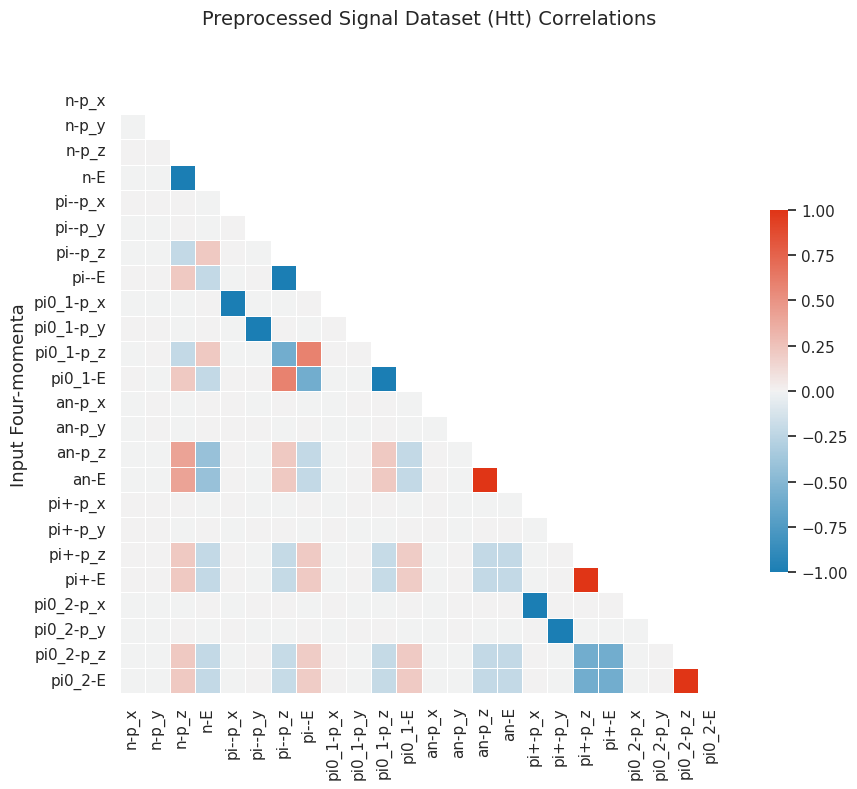

In [47]:
corre_plot(df_rhorho_H_process, figtitle='Preprocessed Signal Dataset (Htt) Correlations', ax_lable= 'Input Four-momenta ')

In [48]:
points_S_B = pickle.load(open(args.IN+'/events_w_background.pk','rb'))
background=[]
background.append(points_S_B.train.x[points_S_B.train.weights.sum(axis=1)==0])
background.append(points_S_B.valid.x[points_S_B.valid.weights.sum(axis=1)==0])
background.append(points_S_B.test.x[points_S_B.test.weights.sum(axis=1)==0])
background=np.concatenate(background)

In [49]:
df_rhorho_Z_process = pd.DataFrame(background)
df_rhorho_Z_process.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])
df_rhorho_Z_process

n                                     pi-                      \
             p_x       p_y       p_z         E       p_x       p_y       p_z   
0      -0.029246 -0.217681  1.138138 -1.138485 -0.767399  1.467279  0.186209   
1      -1.105534  0.760022  0.581389 -0.580869 -1.566601 -0.162662  0.558257   
2       1.188350  0.917880 -2.081946  2.081578 -1.121514  1.415153 -0.025489   
3      -0.038359 -1.052267  0.409695 -0.410057  0.319752  0.104365 -2.820214   
4       0.207637  1.075423  0.624430 -0.624406  0.651947  1.681681  0.265484   
...          ...       ...       ...       ...       ...       ...       ...   
999995  1.352666 -1.258502 -0.231840  0.232147  0.107222  0.089965  1.221524   
999996 -0.723329 -1.267842  0.657233 -0.656092  1.161263  0.425932  0.242341   
999997 -0.186002 -1.019867  0.679336 -0.679322 -0.339648  0.806412 -1.083118   
999998 -0.245376 -1.635864  0.053136 -0.052870 -0.457123  1.284030  0.951862   
999999 -0.560946 -1.145850  0.562620 -0.562308 -0.539364  1.147734 -0.518151   

                     pi0_1            ...        an                 pi+  \
               E       p_x       p_y  ...       p_z         E       p_x   
0      -0.186284  0.767399 -1.467279  ...  0.093389  0.093053 -0.219354   
1      -0.558305  1.566601  0.162662  ...  1.167225  1.167403 -1.156215   
2       0.025461  1.121514 -1.415153  ... -1.159215 -1.158805 -0.403827   
3       2.820470 -0.319752 -0.104365  ... -1.150847 -1.151231 -1.406366   
4      -0.265487 -0.651947 -1.681681  ...  0.166337  0.166235 -1.605712   
...          ...       ...       ...  ...       ...       ...       ...   
999995 -1.221916 -0.107222 -0.089965  ... -0.258391 -0.258065  0.852293   
999996 -0.242562 -1.161263 -0.425932  ...  3.057873  3.057707  0.816323   
999997  1.083028  0.339648 -0.806412  ...  0.772161  0.771786  2.013393   
999998 -0.951804  0.457123 -1.284030  ...  0.557357  0.557307 -0.557220   
999999  0.518016  0.539364 -1.147734  ...  1.374774  1.374704 -1.006089   

                                         pi0_2                                
             p_y       p_z         E       p_x       p_y       p_z         E  
0       1.477120 -0.612311 -0.612385  0.219354 -1.477120  1.866117  1.866255  
1       0.243600 -1.038149 -1.038133  1.156215 -0.243600  0.314231  0.314049  
2      -0.941086 -1.123733 -1.123722  0.403827  0.941086  0.660758  0.660604  
3      -0.834872  1.356685  1.356753  1.406366  0.834872  0.175114  0.175033  
4      -1.019633  0.010269  0.010278  1.605712  1.019633 -0.028416 -0.028404  
...          ...       ...       ...       ...       ...       ...       ...  
999995  0.204471  0.449663  0.449451 -0.852293 -0.204471 -0.305808 -0.306131  
999996  0.996383 -0.507976 -0.508169 -0.816323 -0.996383 -0.920211 -0.920242  
999997  0.565552  0.079282  0.079361 -2.013393 -0.565552 -0.246073 -0.245940  
999998  1.599944 -0.769486 -0.769346  0.557220 -1.599944  0.161923  0.161859  
999999 -1.247059 -0.658846 -0.658839  1.006089  1.247059  0.277650  0.277565  

[1000000 rows x 24 columns]

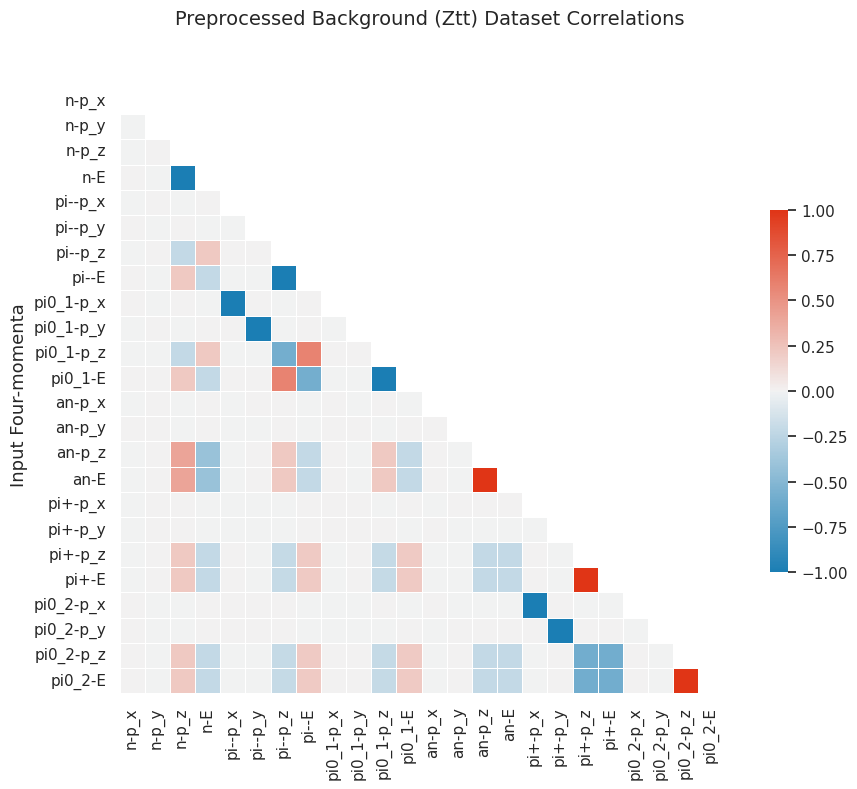

In [50]:
corre_plot(df_rhorho_Z_process, figtitle='Preprocessed Background (Ztt) Dataset Correlations', ax_lable= 'Input Four-momenta ')

In [51]:
df_rhorho_argmax = pd.DataFrame(points_S.train.argmaxs)
df_rhorho_argmax.columns = ['argmaxs']

In [52]:
df_rhorho_argmax

,argmaxs
0,5.158506
1,5.811205
2,5.916572
3,4.052642
4,1.194965
...,...
799995,0.988411
799996,5.775754
799997,1.003346
799998,0.995924


In [53]:
df_rhorho_weights = pd.DataFrame(points_S.train.weights)
df_rhorho_weights.columns = pd.MultiIndex.from_arrays([sum([['weights']*11],[]), df_rhorho_weights.columns])

In [54]:
df_rhorho_weights

weights                                                              \
              0         1         2         3         4         5         6    
0       1.511987  1.239172  0.997177  0.878434  0.928301  1.127728  1.400543   
1       1.232917  1.055691  0.808296  0.585229  0.471693  0.511055  0.688280   
2       1.023842  0.833893  0.542371  0.260628  0.096281  0.112104  0.302054   
3       0.847710  0.609226  0.622559  0.882616  1.290064  1.689272  1.927756   
4       0.884181  1.071781  1.132545  1.043265  0.838042  0.595264  0.407664   
...          ...       ...       ...       ...       ...       ...       ...   
799995  1.466650  1.551323  1.557551  1.482954  1.356027  1.225251  1.140578   
799996  1.089216  0.829611  0.477659  0.167792  0.018370  0.086467  0.346072   
799997  0.773619  0.962591  0.980668  0.820945  0.544430  0.256742  0.067769   
799998  1.084564  1.297602  1.315662  1.131845  0.816364  0.489721  0.276683   
799999  1.933376  1.852945  1.459096  0.902264  0.395142  0.131432  0.211863   

                                                
              7         8         9         10  
0       1.642538  1.761281  1.711414  1.511987  
1       0.935675  1.158743  1.272279  1.232917  
2       0.593576  0.875318  1.039665  1.023842  
3       1.914424  1.654367  1.246918  0.847710  
4       0.346900  0.436180  0.641403  0.884181  
...          ...       ...       ...       ...  
799995  1.134351  1.208947  1.335874  1.466650  
799996  0.698025  1.007891  1.157313  1.089216  
799997  0.049692  0.209416  0.485931  0.773619  
799998  0.258623  0.442439  0.757921  1.084564  
799999  0.605712  1.162544  1.669666  1.933376  

[800000 rows x 11 columns]

In [55]:
df_rhorho_input = pd.concat([df_rhorho_H_process, df_rhorho_weights], axis=1)

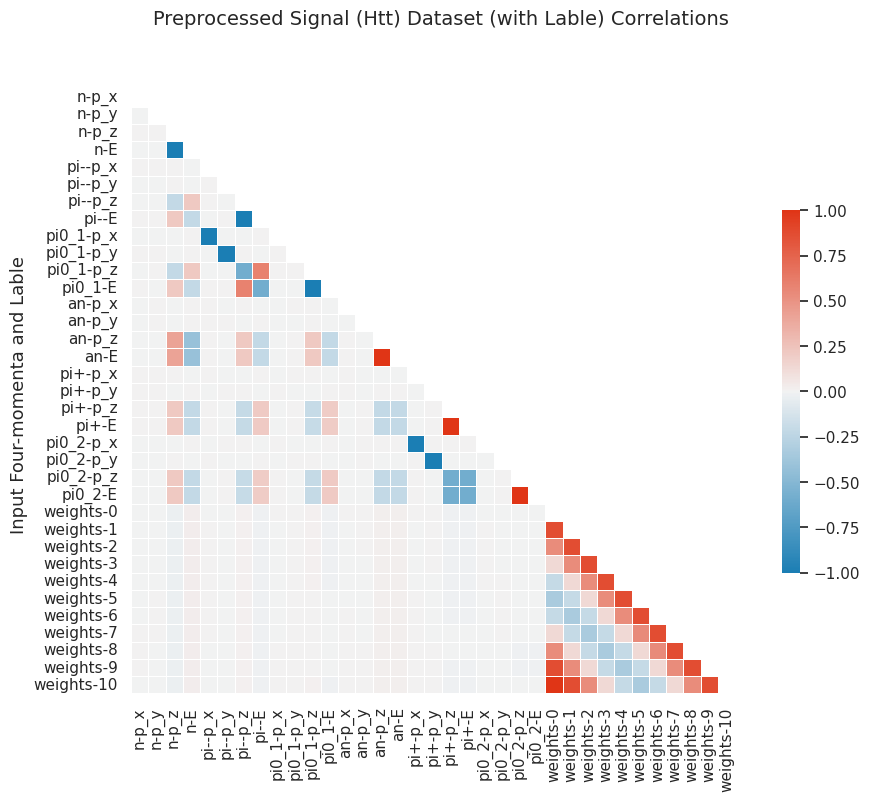

In [56]:
corre_plot(df_rhorho_input, figtitle='Preprocessed Signal (Htt) Dataset (with Lable) Correlations', ax_lable= 'Input Four-momenta and Lable ')